# Shifted Beta-Geometric Model with Cohorts and Covariates

The Shifted Beta-Geometric (sBG) model was first introduced in ["How to Project Customer Retention"](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) by Hardie & Fader in 2007. It is ideal for predicting customer behavior in business cases involving contract renewals or recurring subscriptions, and the original model has been expanded in PyMC-Marketing to support multidimensional cohorts and covariates. In this notebook we will reproduce the research results, then proceed to a comprehensive example with EDA and additional predictive methods.

## Setup Notebook

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr
from dateutil.relativedelta import relativedelta
from pymc_extras.prior import Prior

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.constrained_layout.use"] = True

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
seed = sum(map(ord, "sBG Model"))
rng = np.random.default_rng(seed)

## Load Data

Data must be aggregrated in the following format for model fitting:

- `customer_id` is an index of unique identifiers for each customer
- `recency` indicates the most recent time period a customer was still active
- `T` is the maximum observed time period for a given cohort
- `cohort` indicates the cohort assignment for each customer

For active customers, `recency` is equal to `T`, and all customers in a given cohort share the same value for `T`. If a customer cancelled their contract and restarted at a later date, a new `customer_id` must be assigned for the restart.

Sample data is available in the PyMC-Marketing repo. To see the code used to generate this data, refer to `generate_sbg_data()` in `scripts/clv_data_generation.py` in the repo.

In [5]:
cohort_df = pd.read_csv(
    "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/refs/heads/main/data/sbg_cohorts.csv"
)
cohort_df

customer_id  recency  T   cohort
0               1        1  8  highend
1               2        1  8  highend
2               3        1  8  highend
3               4        1  8  highend
4               5        1  8  highend
...           ...      ... ..      ...
1995         1996        8  8  regular
1996         1997        8  8  regular
1997         1998        8  8  regular
1998         1999        8  8  regular
1999         2000        8  8  regular

[2000 rows x 4 columns]

This dataset was generated from the first 8 time periods in Table 1 of the research paper, which provides survival rates for two types of customers ("Regular" and "Highend") over 13 time periods:

In [6]:
# Data from research paper
research_data = pd.DataFrame(
    {
        "regular": [
            100.0,
            63.1,
            46.8,
            38.2,
            32.6,
            28.9,
            26.2,
            24.1,
            22.3,
            20.7,
            19.4,
            18.3,
            17.3,
        ],
        "highend": [
            100.0,
            86.9,
            74.3,
            65.3,
            59.3,
            55.1,
            51.7,
            49.1,
            46.8,
            44.5,
            42.7,
            40.9,
            39.4,
        ],
    }
)
research_data

regular  highend
0     100.0    100.0
1      63.1     86.9
2      46.8     74.3
3      38.2     65.3
4      32.6     59.3
5      28.9     55.1
6      26.2     51.7
7      24.1     49.1
8      22.3     46.8
9      20.7     44.5
10     19.4     42.7
11     18.3     40.9
12     17.3     39.4

This is also a useful format for model evaluation. In survival analysis parlance, customers with `recency==T` are "right-censored". If we fit a model to the first $8$ time periods, we can test predictions on censored data over the remaining $5$.

In [7]:
# Utility function to aggregate model fit data for evaluation
def survival_rate_aggregation(customer_df: pd.DataFrame):
    """Aggregate customer-level sBG data into survival rates by cohort over time."""
    # Group by cohort to get total counts
    cohorts = customer_df["cohort"].unique()

    # Create a list to store results for each time period
    results = []

    # For each time period from 0 to T (8 in this case)
    for t in range(customer_df["T"].max()):
        row_data = {"T": t}

        for cohort in cohorts:
            cohort_data = customer_df[customer_df["cohort"] == cohort]
            total_customers = len(cohort_data)

            if t == 0:
                # At time 0, 100% retention
                retention_pct = 100.0
            else:
                # Count customers who survived at least to time t (recency >= t)
                survived = len(cohort_data[cohort_data["recency"] > t])
                retention_pct = (survived / total_customers) * 100

            row_data[cohort] = retention_pct

        results.append(row_data)

    return pd.DataFrame(results)


# Aggregate model fit data
df_actual = survival_rate_aggregation(cohort_df)

# Assign T column to research data and truncate to 8 periods
research_data["T"] = research_data.index
df_expected = research_data[["T", "highend", "regular"]].query("T<8").copy()

# Assert aggregated dataset is equivalent to the values in the research paper
pd.testing.assert_frame_equal(df_actual, df_expected)

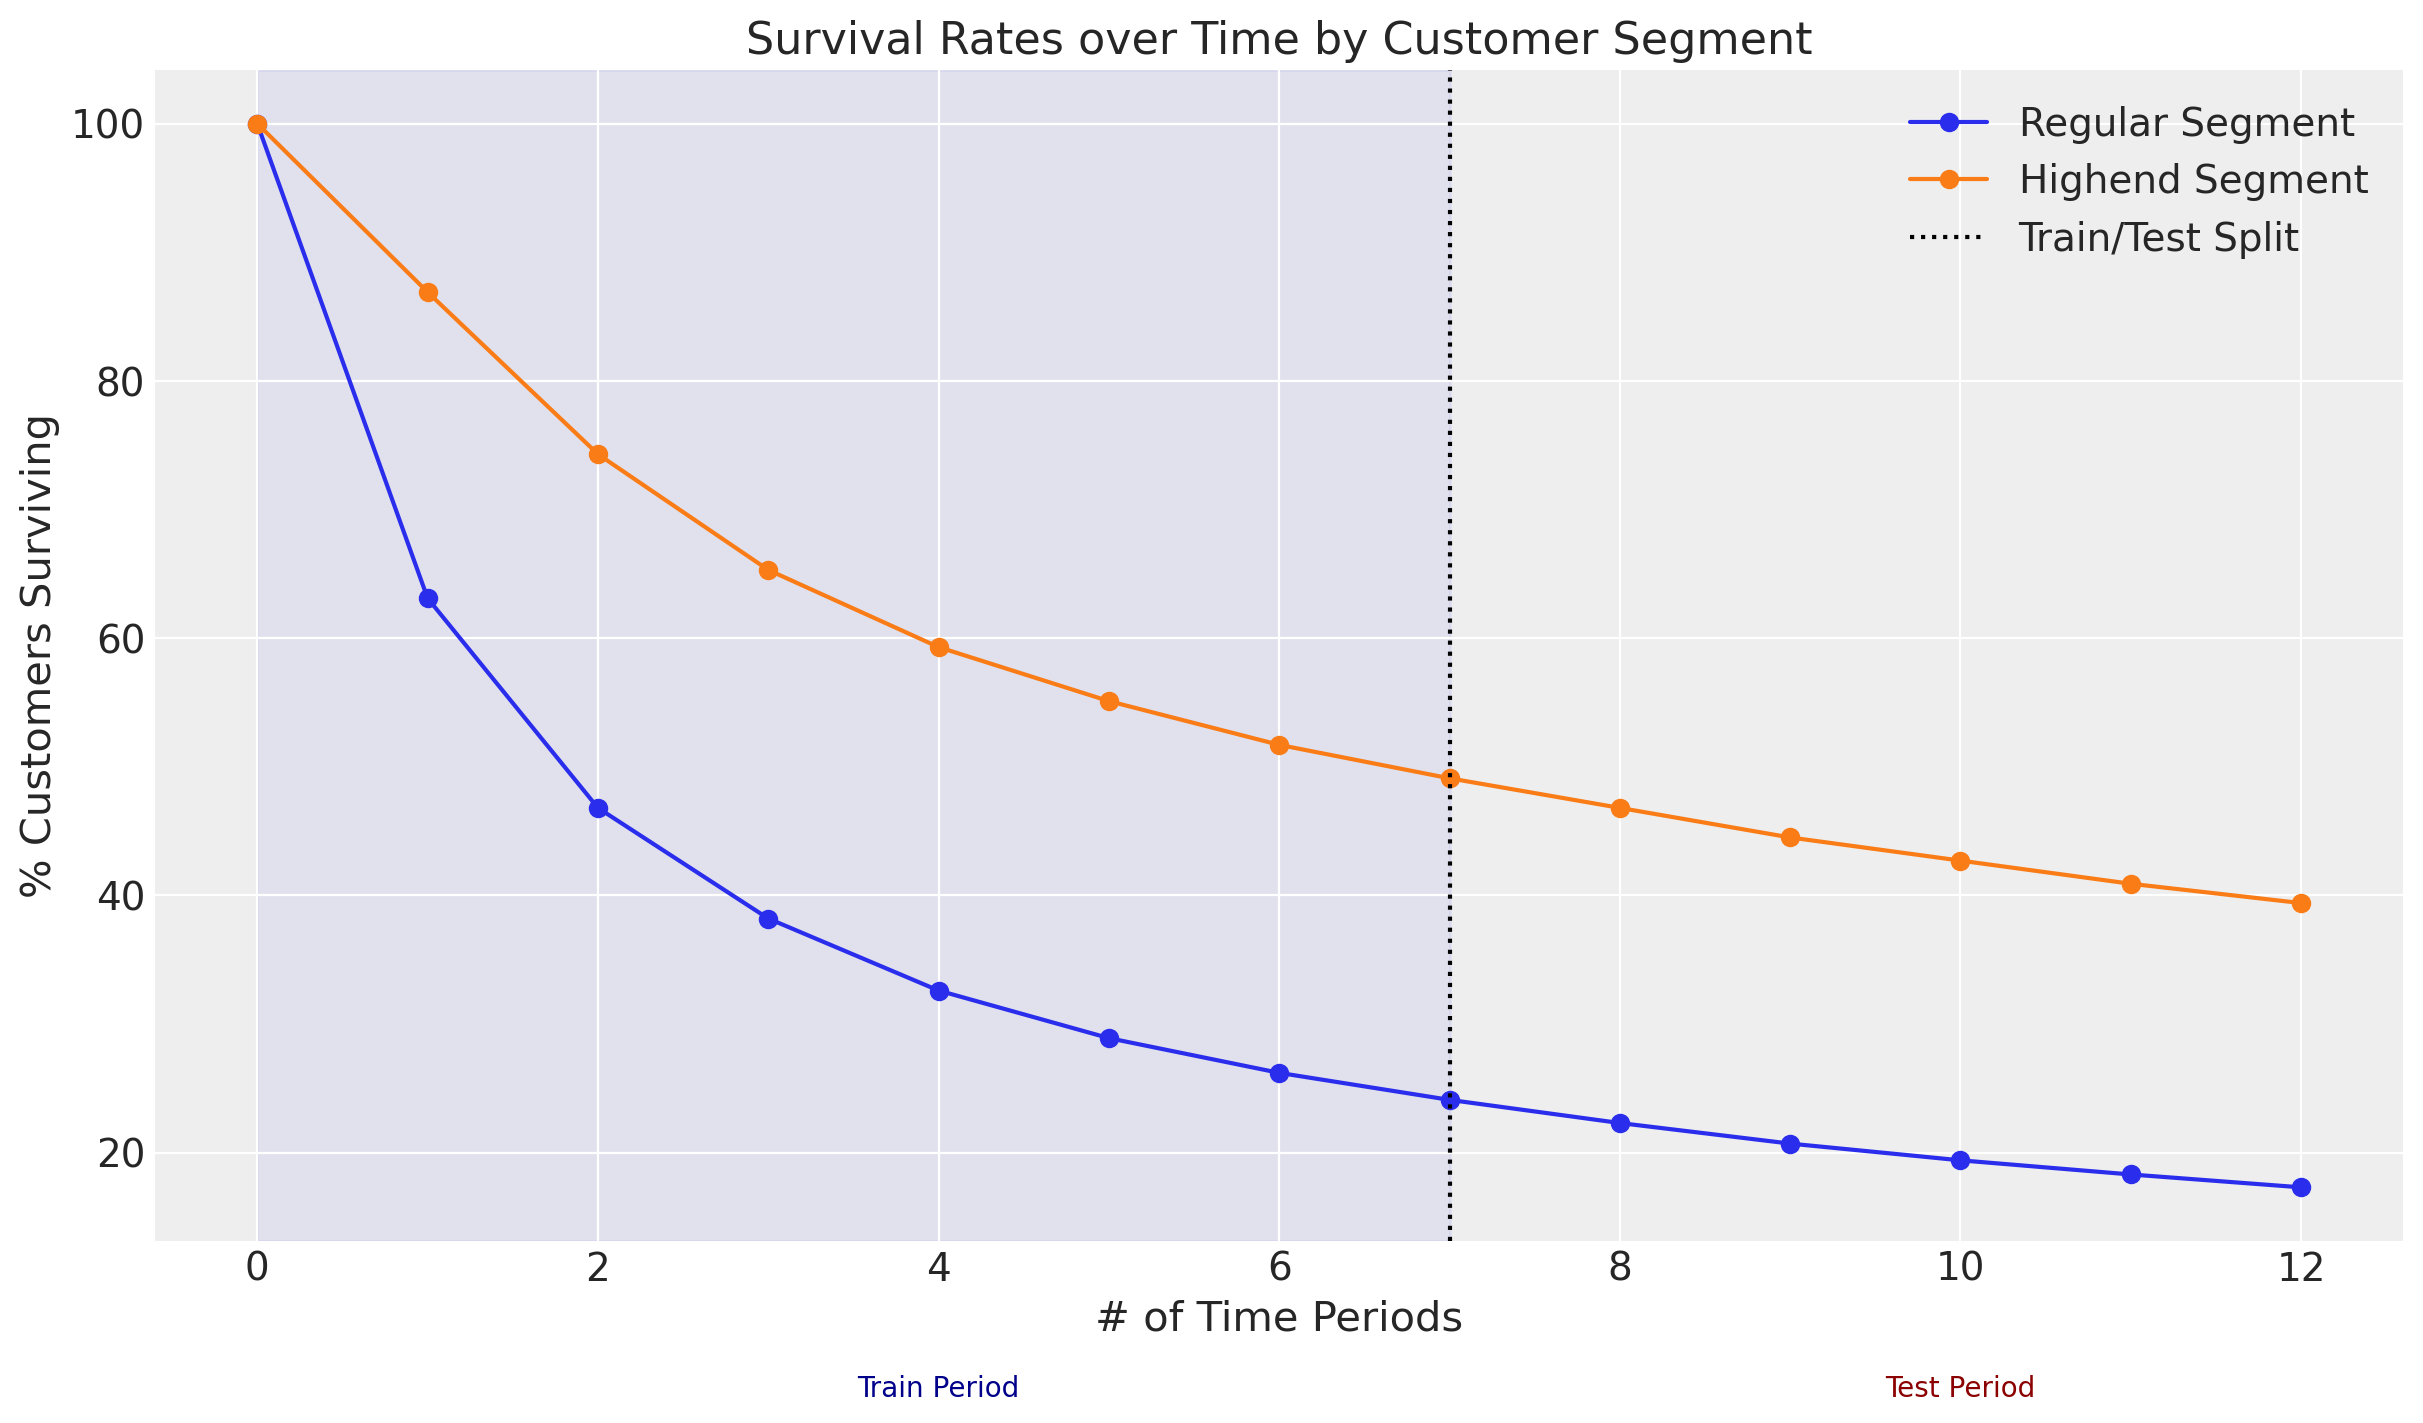

In [8]:
plt.plot(research_data["regular"].values, marker="o", label="Regular Segment")
plt.plot(research_data["highend"].values, marker="o", label="Highend Segment")
plt.ylabel("% Customers Surviving")
plt.xlabel("# of Time Periods")
# Add vertical line separating train/test periods
plt.axvline(7, ls=":", color="k", label="Train/Test Split")
plt.legend()

# Highlight train/test regions
plt.axvspan(0, 7, alpha=0.05, color="blue", zorder=0)

# Label training and test periods
plt.text(4, 1, "Train Period", ha="center", fontsize=10, color="darkblue")
plt.text(10, 1, "Test Period", ha="center", fontsize=10, color="darkred")

plt.title("Survival Rates over Time by Customer Segment");

Because all customers began their contracts in the same time period, *segment* is a more appropriate term than *cohort*, but we can model both with the same functionality. Let's proceed to modeling.

# Model Fitting

The sBG model has the following assumptions:

1. Individual customer lifetime durations are characterized by the (shifted) Geometric distribution, with cancellation probability $\theta$.
2. Heterogeneity in $\theta$ follows a Beta distribution with shape parameters $\alpha$ and $\beta$.

If we take the expectation across the distribution of $\theta$, we can derive a likelihood function to estimate parameters $\alpha$ and $\beta$ for the customer population. For more details on the `ShiftedBetaGeometric` mixture distribution, please refer to the [documentation](https://www.pymc-marketing.io/en/latest/api/generated/pymc_marketing.clv.distributions.ShiftedBetaGeometric.html#pymc_marketing.clv.distributions.ShiftedBetaGeometric).

The original frequentist model assumes a single cohort of customers who all started their contracts in the same time period. This requires fitting a separate model for each cohort. However, in PyMC-Marketing we can fit all cohorts in a single hierarchical Bayesian model!

Here are the parameter estimates from the research paper for a sBG model fit with the provided data using Maximum Likelihood Estimation (MLE):

In [9]:
# MLE estimates from the paper
mle_research_parameters = {
    # "cohort": [alpha, beta]
    "regular": [0.704, 1.182],
    "highend": [0.668, 3.806],
}

## Reproduce Research Results with Cohorts

### Model Fitting with MAP

The Bayesian equivalent of a frequentist MLE fit is Maximum a Posteriori (MAP) with "flat" priors. A flat prior can be used when the user is agnostic about the observed data, holding no prior beliefs or assumptions. Since $\alpha$ and $\beta$ must be positive values, let's configure our Bayesian `ShiftedBetaGeoModel` with `HalfFlat` priors:

In [ ]:
sbg_map = clv.ShiftedBetaGeoModel(
    model_config={
        "alpha": Prior("HalfFlat", dims="cohort"),
        "beta": Prior("HalfFlat", dims="cohort"),
    },
)
sbg_map.fit(data=cohort_df, method="map")
sbg_map.fit_summary()

Output()

alpha[highend]    0.668
alpha[regular]    0.704
beta[highend]     3.806
beta[regular]     1.182
Name: value, dtype: float64

MAP parameter estimates are identical to those in the research. We can also use these parameters recover the latent $\theta$ dropout distributions and recreate Figure 6 in the research paper:

#### Visualize Latent Dropout Distributions

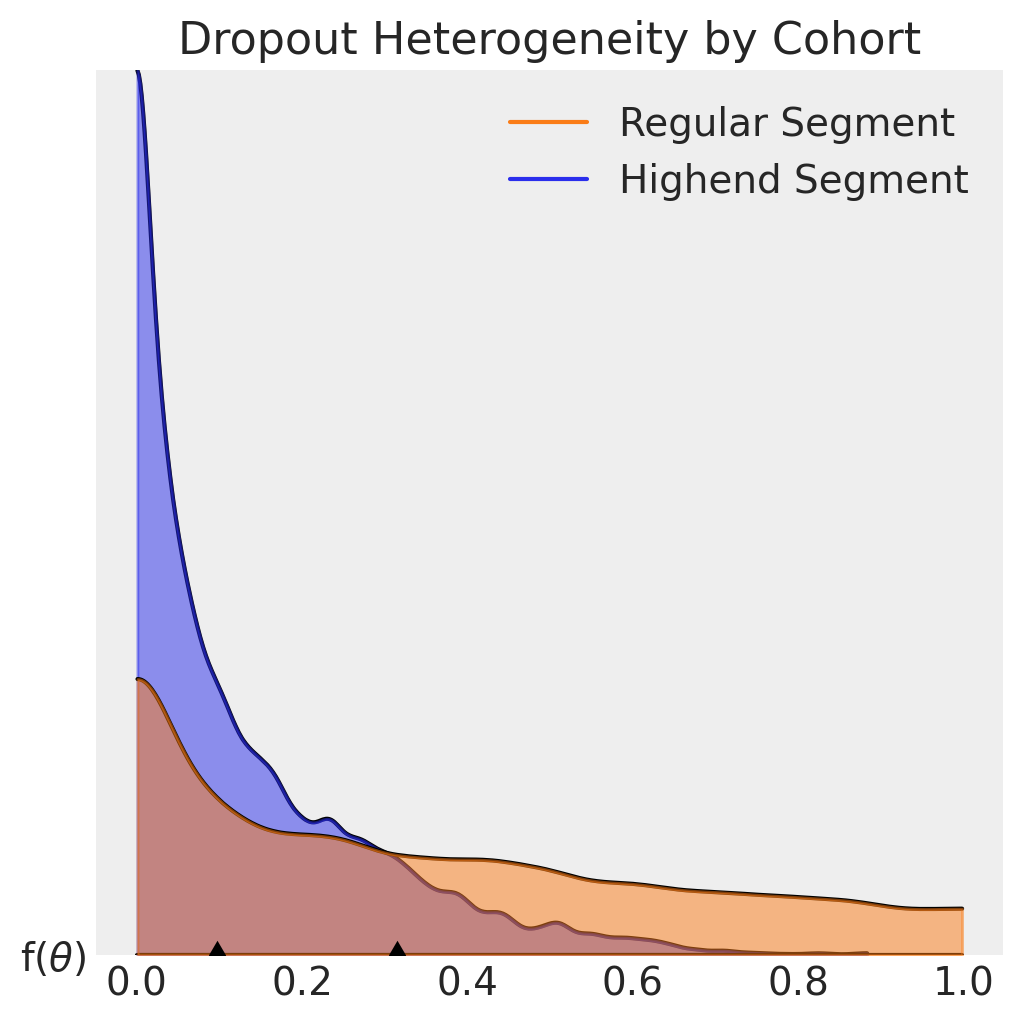

In [11]:
# Extract alpha and beta from fit results
alpha = sbg_map.fit_result["alpha"]
beta = sbg_map.fit_result["beta"]

# Specifiy number of draws from latent theta distributions
n_samples = 4_000

cohorts = alpha.coords["cohort"].values
dropout_samples = np.array(
    [
        rng.beta(
            alpha.sel(cohort=c).values.item(),  # Use .item() to get scalar
            beta.sel(cohort=c).values.item(),  # Use .item() to get scalar
            size=n_samples,
        )
        for c in cohorts
    ]
).T  # Transpose to get (samples, cohorts) shape

# Create xarray DataArray with chain, draw, and cohort dimensions
dropout = xr.DataArray(
    dropout_samples[np.newaxis, :, :],
    dims=("chain", "draw", "cohort"),
    coords={
        "chain": [0],
        "draw": np.arange(n_samples),
        "cohort": cohorts,
    },
    name=r"f($\theta$)",
)

# Convert to InferenceData for plotting in ArviZ
dropout_idata = az.convert_to_inference_data(dropout)

axes = az.plot_forest(
    [dropout_idata.sel(cohort="highend"), dropout_idata.sel(cohort="regular")],
    model_names=["Highend Segment", "Regular Segment"],
    kind="ridgeplot",
    combined=True,
    colors=["C0", "C1"],
    hdi_prob=1,
    ridgeplot_alpha=0.5,
    ridgeplot_overlap=1e5,
    ridgeplot_truncate=True,
    ridgeplot_quantiles=[0.5],
    figsize=(5, 5),
)
axes[0].set_title("Dropout Heterogeneity by Cohort");

It is evident from the plots dropout probabilities skew lower for customers in the Highend segment, who have a median contract cancellation probability of about 10% for each renewal period. The Regular segment median exceeds 30% in comparison.

Models can be fit very quickly with MAP, but there are important caveats to consider when recreating the frequentist MLE approach:
- Flat priors are slow to converge, and can be unstable in practice because no regularization is applied to model parameters during fitting.
- MAP/MLE fits do not provide credibility intervals for predictions.

In the Bayesian paradigm, prior distributions are derived from business domain knowledge and experimentation. With priors we can regularize parameter estimates, reduce model fit times, and with MCMC sampling infer the posterior distributions, illustrating uncertainty in our parameter estimates as well as enabling prediction intervals.

### Model Fitting with MCMC

The default sampler in PyMC-Marketing is the No-U-Turn Sampler (NUTS), which samples from the posterior by exploring the gradients of the probability space. The default prior configuration for `ShiftedBetaGeoModel` works well for many use cases:

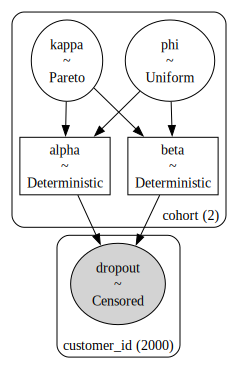

In [ ]:
sbg_mcmc = clv.ShiftedBetaGeoModel()
sbg_mcmc.build_model(
    data=cohort_df
)  # optional step to view model config and run prior predictive checks
sbg_mcmc.graphviz()

The default `kappa` and `phi` priors are pooling distributions that improve the speed & reliability of model fits, but can be omitted by specifying custom `alpha` and `beta` priors in the `model_config`. Note the number of cohorts and customers are also listed, and the dropout $\theta$ distribution is censored just like the dataset.

Let's fit a MCMC model and visualize the results:

In [ ]:
sbg_mcmc.fit(
    method="mcmc", random_seed=rng
)  # if build_model() is called, no need to pass data into fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

In [14]:
sbg_mcmc.fit_summary(var_names=["alpha", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[highend]  0.670  0.112   0.477    0.874      0.002    0.003    2305.0   
alpha[regular]  0.703  0.065   0.591    0.829      0.001    0.001    3235.0   
beta[highend]   3.821  0.867   2.313    5.370      0.020    0.024    1897.0   
beta[regular]   1.181  0.152   0.904    1.464      0.003    0.002    2480.0   

                ess_tail  r_hat  
alpha[highend]    2512.0    1.0  
alpha[regular]    3186.0    1.0  
beta[highend]     2300.0    1.0  
beta[regular]     2659.0    1.0

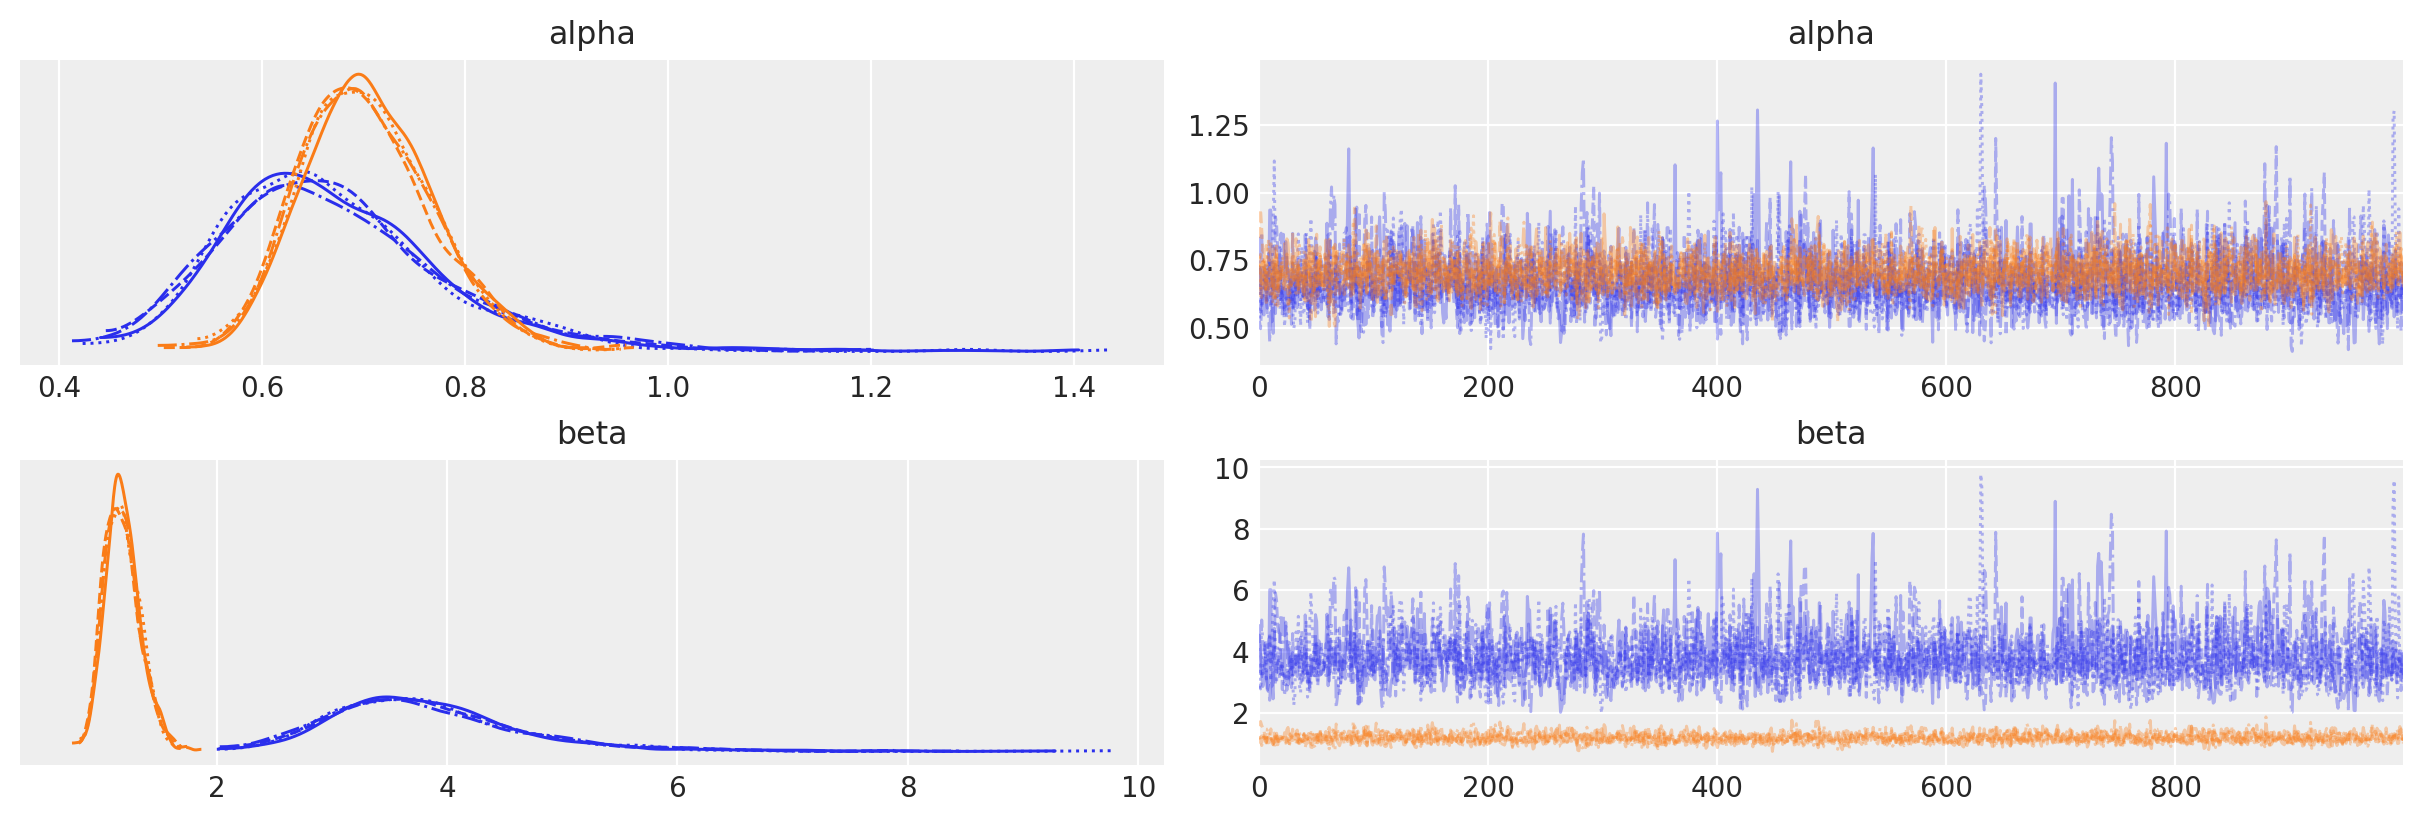

In [15]:
az.plot_trace(sbg_mcmc.idata, var_names=["alpha", "beta"]);

Fit summaries and trace plots look good. Let's compare the fitted posterior distributions to the scalar parameter estimates from the research:

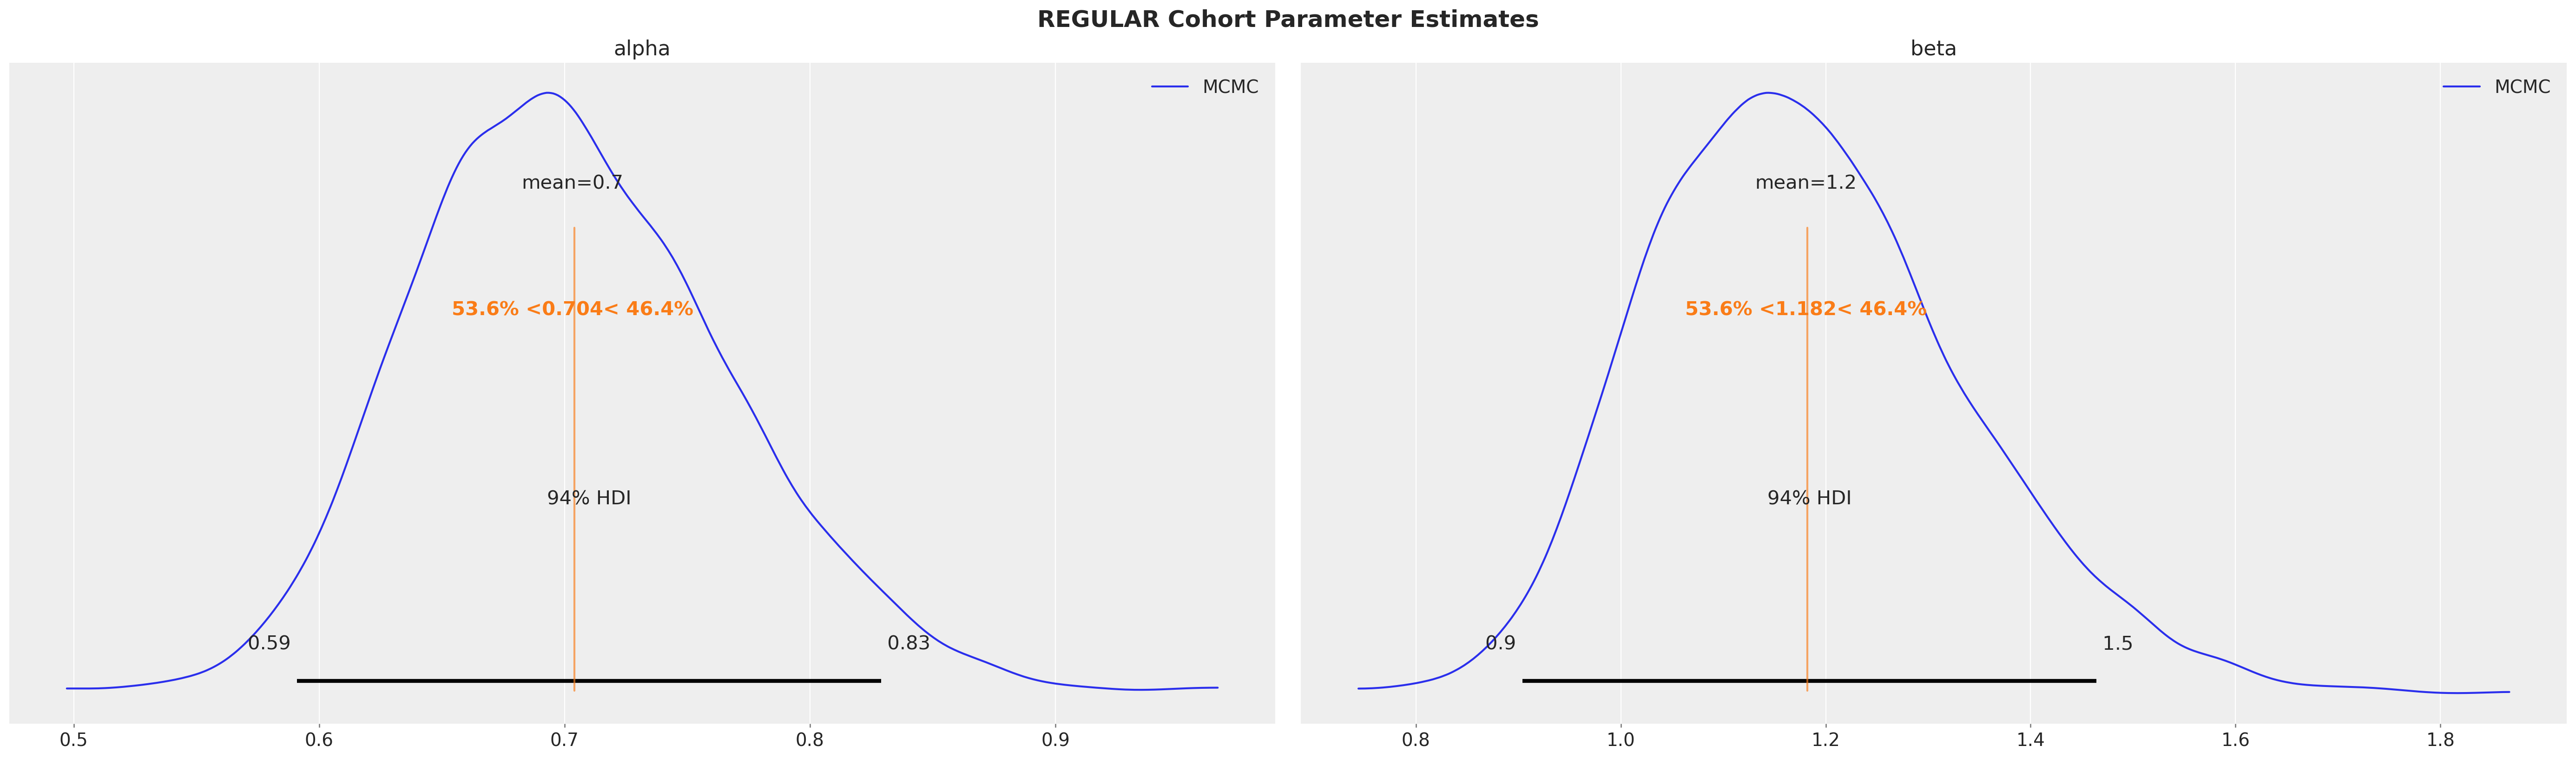

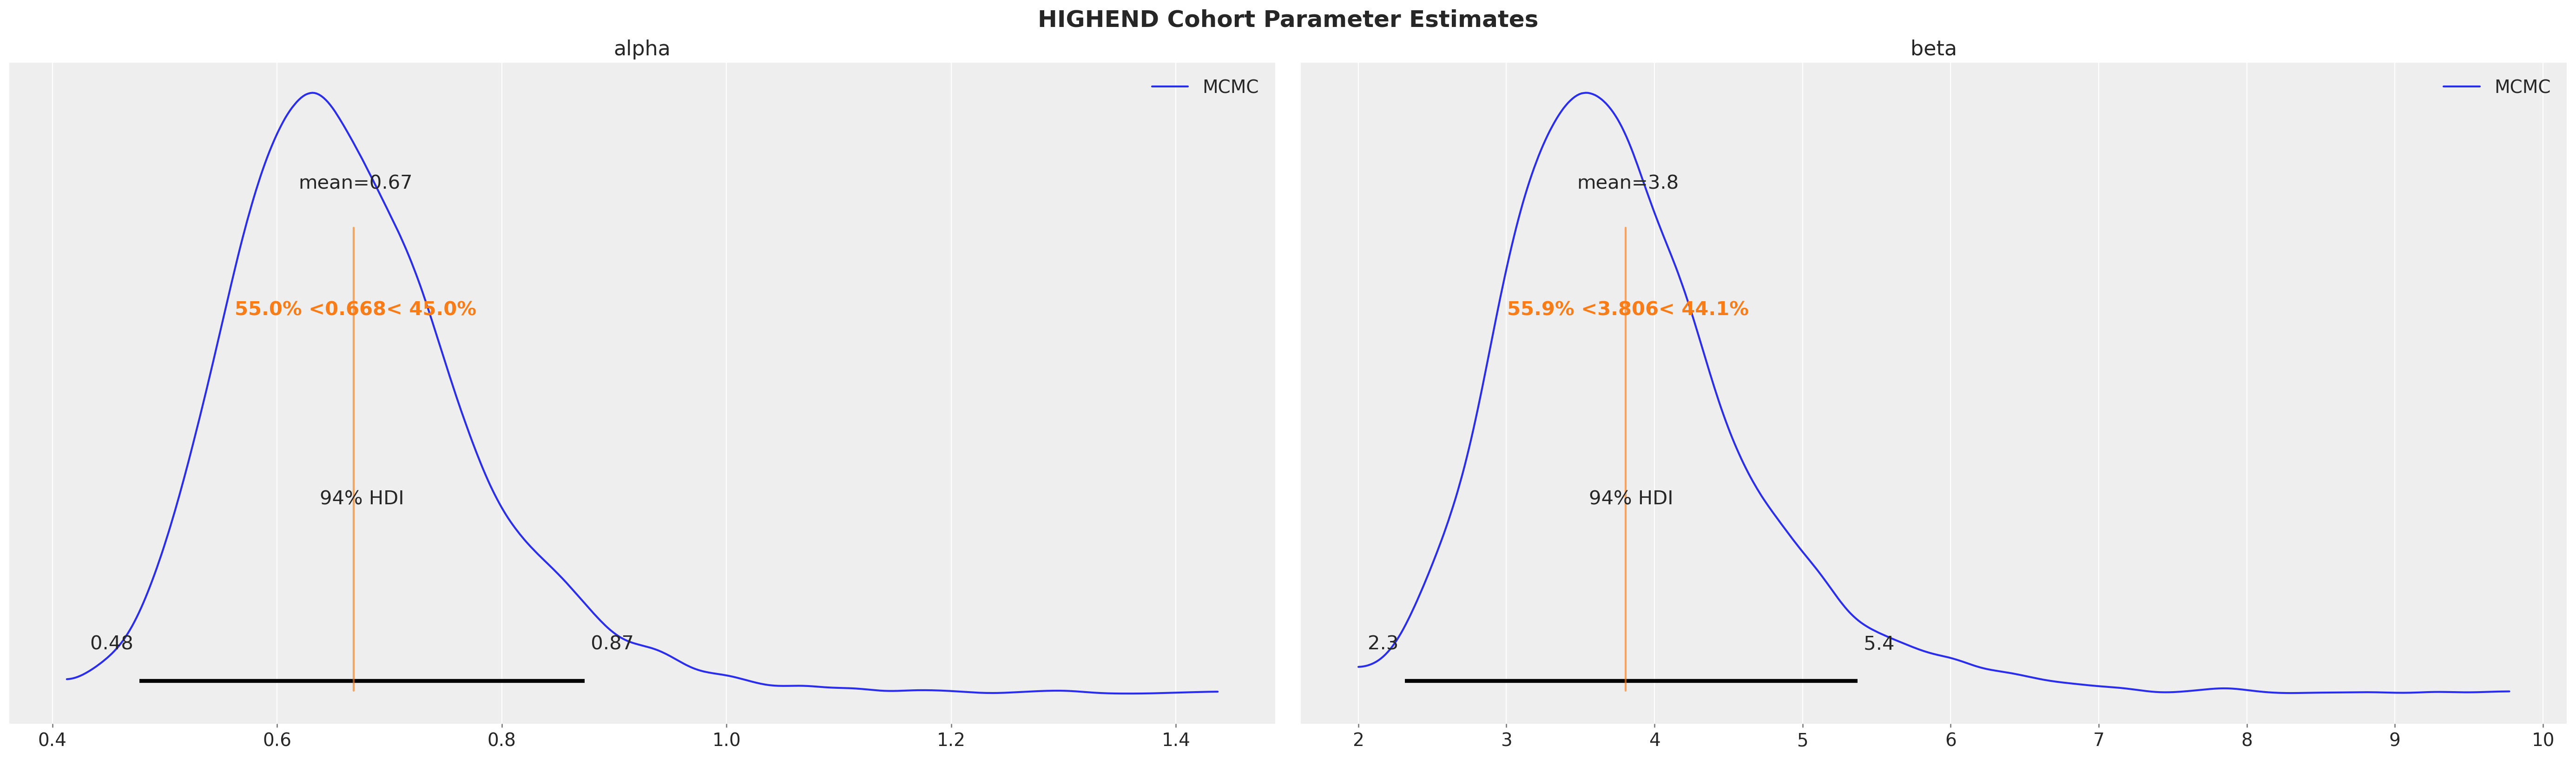

In [17]:
for var_name in mle_research_parameters.keys():
    az.plot_posterior(
        sbg_mcmc.idata.sel(cohort=var_name),
        var_names=["alpha", "beta"],
        ref_val=mle_research_parameters[var_name],
        label="MCMC",
    )
    plt.gcf().suptitle(
        f"{var_name.upper()} Cohort Parameter Estimates", fontsize=18, fontweight="bold"
    )

Fitted posterior mean values align with the MLE values described in the research paper! MCMC sampling also gives us useful information about the uncertainty of the fits. Note how the mean values are within the 94% HDI intervals but not perfectly centered, indicating the posteriors are asymetrical.

### Model Evaluation with Cohorts

Recall the model was fit to the first $8$ time periods and the remaining $5$ were withheld for testing. The `survival_rate_aggregation()` function can be used to summarize the full dataset for model evaluation.

In [16]:
# Aggregating model fit data to get the training period endpoint.
# (This would normally be ran on the full dataset of train/test data, which is already aggregated in this case.)
df_fit_eval = survival_rate_aggregation(cohort_df)

# get T values of test and training data
test_T = len(research_data)
train_T = len(df_fit_eval)

# Create T time period array to run predictions on both train and test time periods
T_eval_range = np.arange(train_T * -1, test_T - train_T, 1)
T_eval_range

array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

We are also running predictions on training (shown as negative) time periods to get the full context.

#### Survival Function
The sBG [*survival function*](https://www.pymc-marketing.io/en/stable/api/generated/classmethods/pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_probability_alive.html#pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_probability_alive) is the probability customers within a given cohort are still active after a specified time period. It is called with `ShiftedBetaGeoModel.expected_probability_alive()`:

In [17]:
expected_survival_rates = xr.concat(
    objs=[
        sbg_mcmc.expected_probability_alive(
            future_t=T,
        )
        for T in T_eval_range
    ],
    dim="T",
).transpose(..., "T")

Plotting credibility intervals for survival rates against observed data:

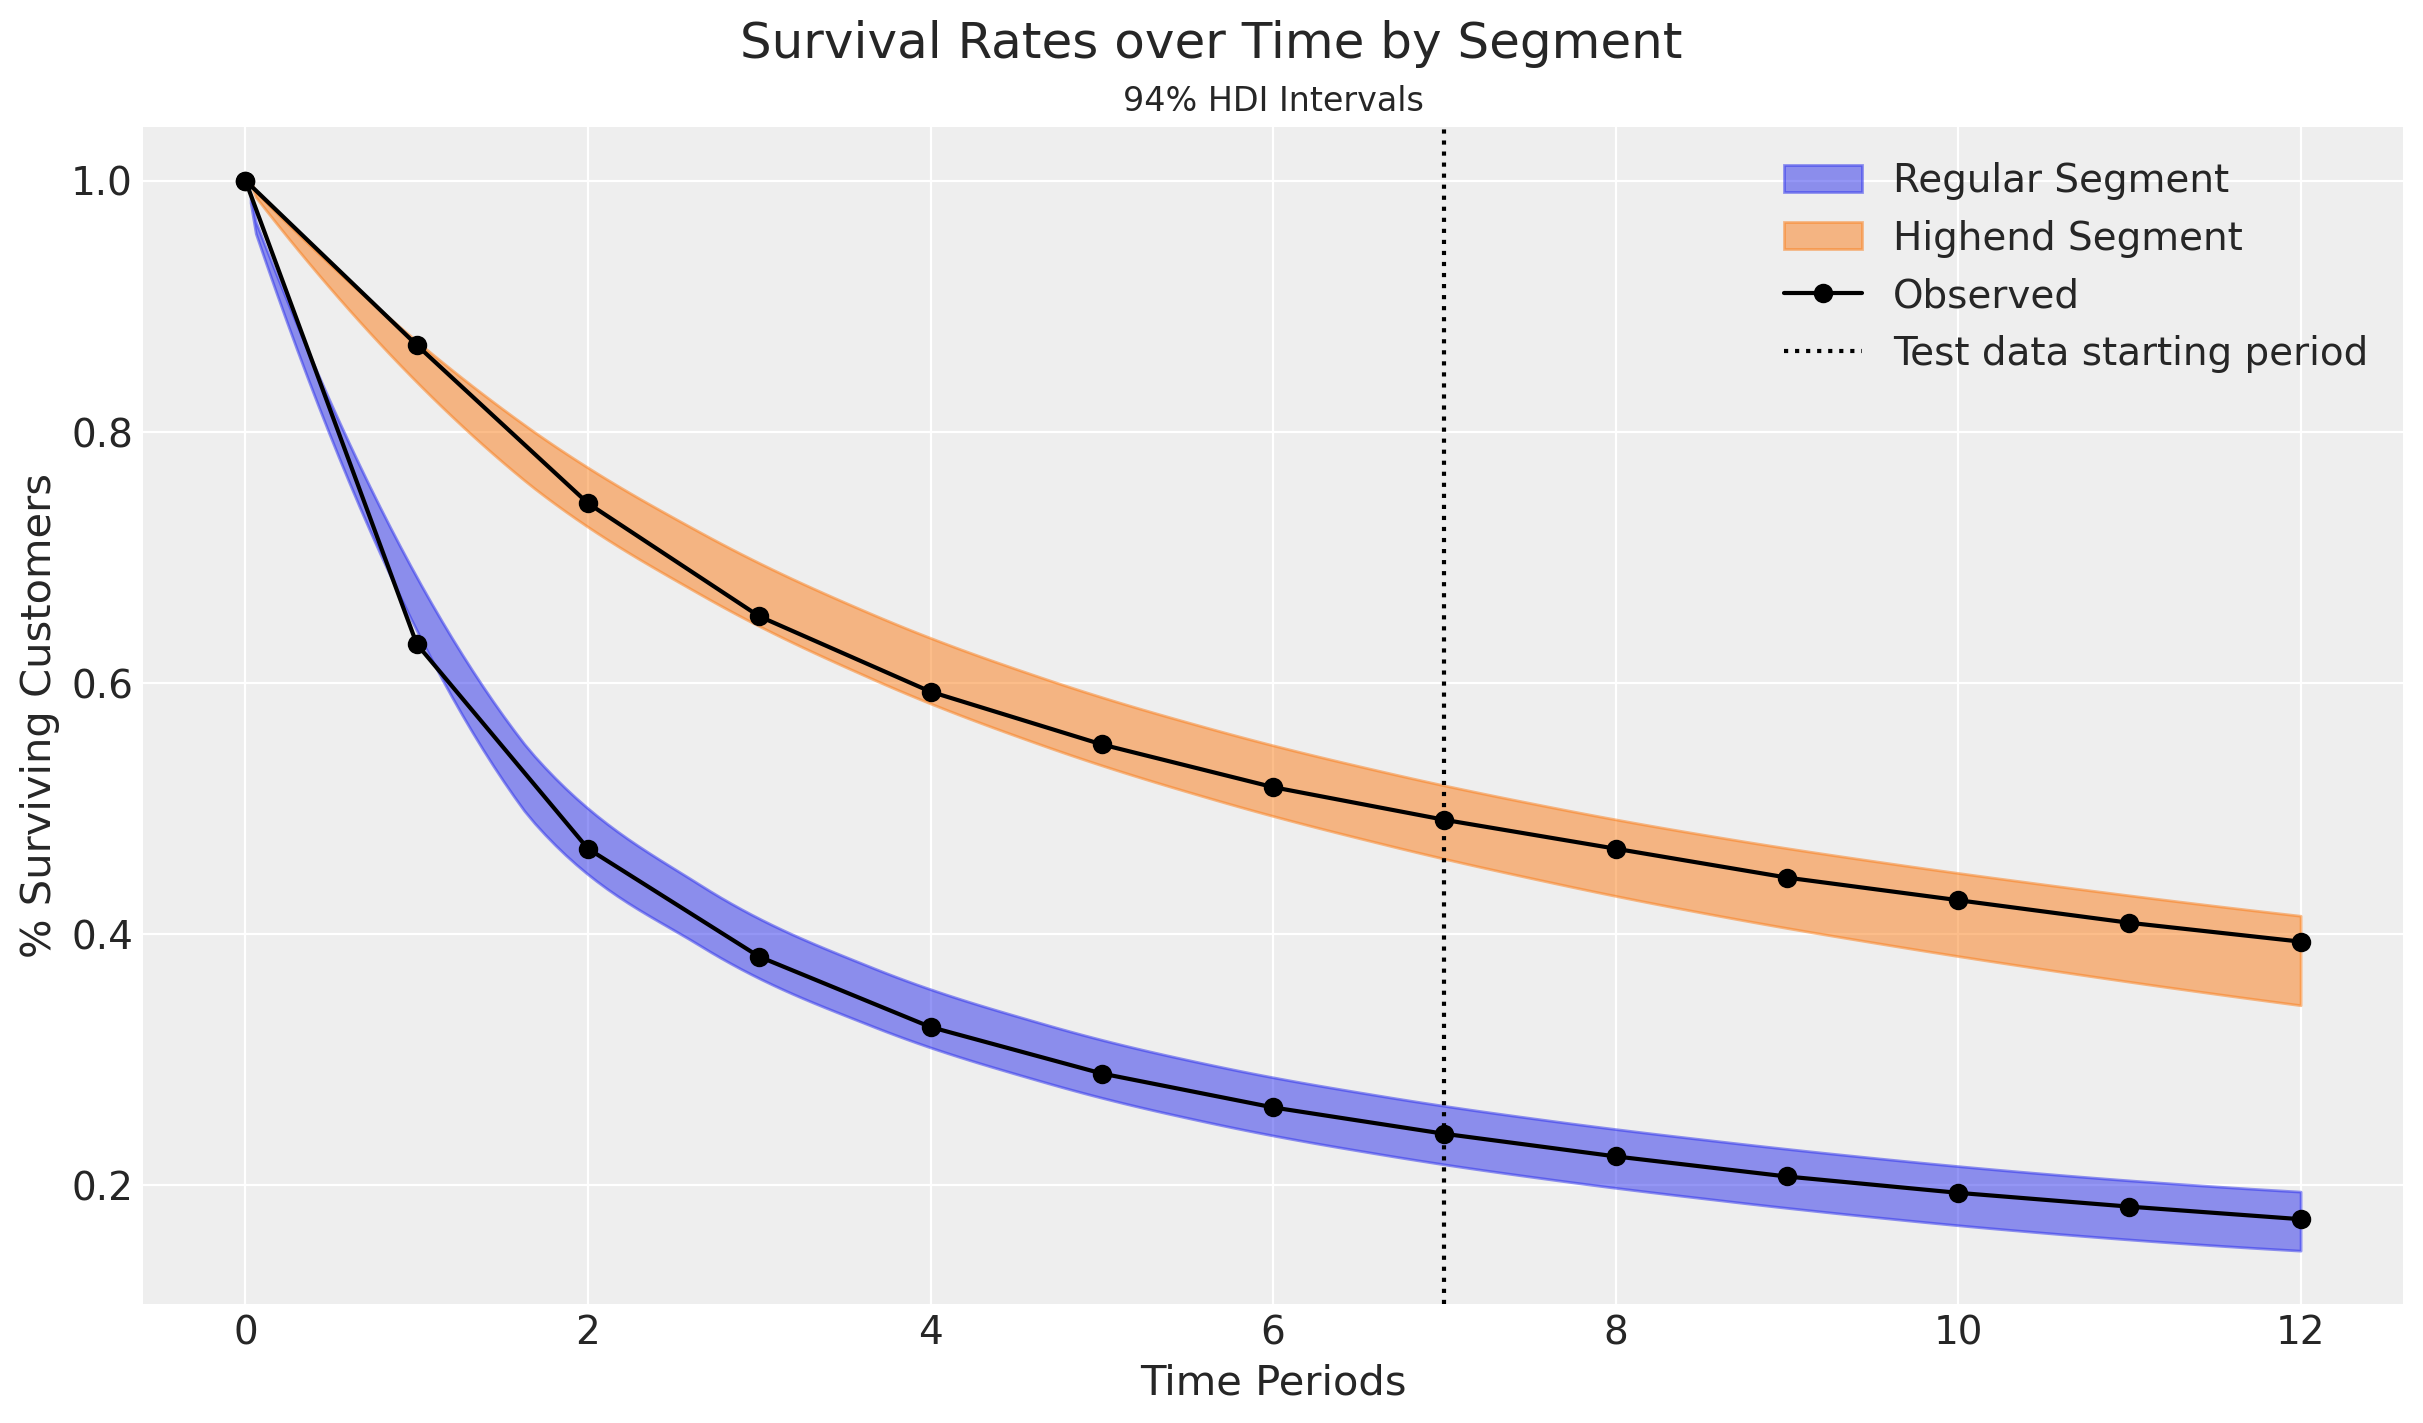

In [18]:
# plot predictions
for i, segment in enumerate(["regular", "highend"]):
    az.plot_hdi(
        range(test_T),
        expected_survival_rates.sel(cohort=segment).mean("cohort"),
        hdi_prob=0.94,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.5, "label": f"{segment.capitalize()} Segment"},
    )

# plot observed
plt.plot(
    range(test_T),
    research_data["highend"] / 100,
    marker="o",
    color="k",
    label="Observed",
)
plt.plot(range(test_T), research_data["regular"] / 100, marker="o", color="k")

plt.ylabel("% Surviving Customers")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k", label="Test data starting period")
plt.legend()
plt.suptitle("Survival Rates over Time by Segment", fontsize=18)
plt.title("94% HDI Intervals", fontsize=12);

Observed survival rates fall well within the 94% credibility intervals!

#### Retention Rate

We can also predict the [*retention rate*](https://www.pymc-marketing.io/en/stable/api/generated/classmethods/pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_retention_rate.html#pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_retention_rate) by cohort, which is defined as the proportion of customers active in period $T-1$ who are still active in period $T$:

In [19]:
# Run retention rate predictions
expected_retention_rates = xr.concat(
    objs=[
        sbg_mcmc.expected_retention_rate(
            future_t=T,
        )
        for T in T_eval_range[1:]  # omit starting time period (see below)
    ],
    dim="T",
).transpose(..., "T")

# Calculate observed retention rates by cohort.
# Initial start period does not have a retention rate, so retention array is 1 time period shorter than observed.
retention_rate_highend_obs = (
    research_data["highend"][1:].values / research_data["highend"][:-1].values
)
retention_rate_regular_obs = (
    research_data["regular"][1:].values / research_data["regular"][:-1].values
)

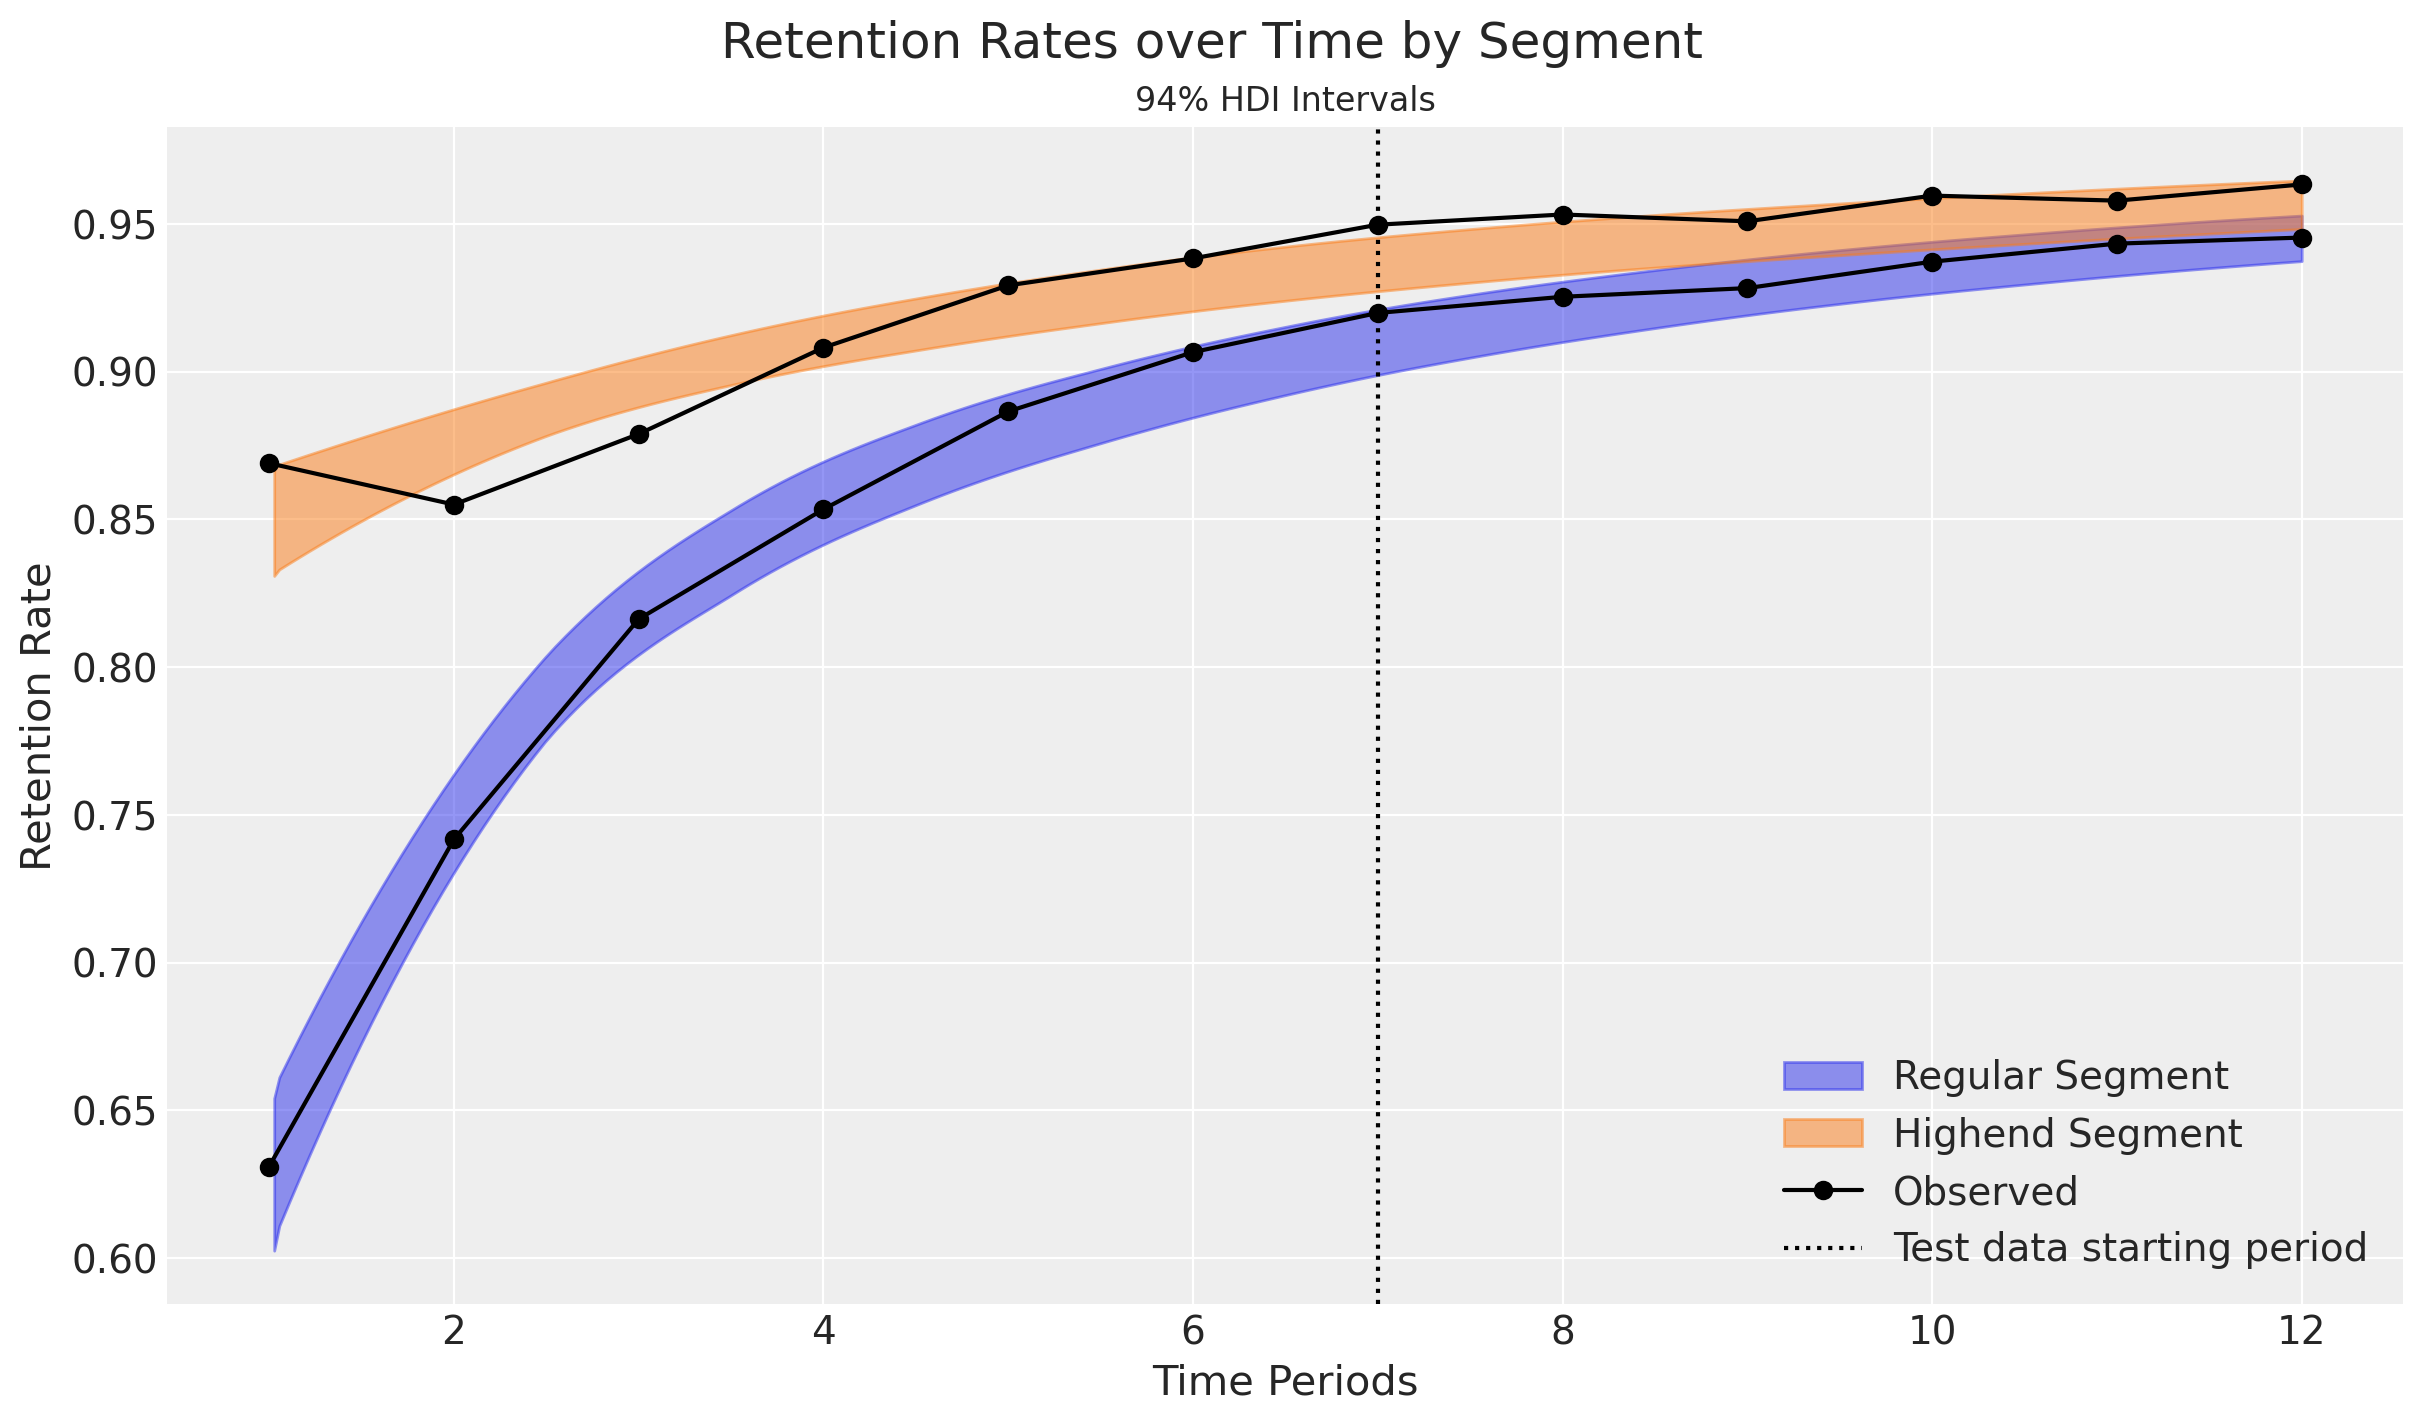

In [20]:
# Plot predictions
for i, segment in enumerate(["regular", "highend"]):
    az.plot_hdi(
        range(1, test_T),
        expected_retention_rates.sel(cohort=segment).mean("cohort"),
        hdi_prob=0.94,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.5, "label": f"{segment.capitalize()} Segment"},
    )

# Plot observed
plt.plot(
    range(1, test_T),
    retention_rate_highend_obs,
    marker="o",
    color="k",
    label="Observed",
)
plt.plot(range(1, test_T), retention_rate_regular_obs, marker="o", color="k")

plt.ylabel("Retention Rate")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k", label="Test data starting period")
plt.legend()
plt.suptitle("Retention Rates over Time by Segment", fontsize=18)
plt.title("94% HDI Intervals", fontsize=12);

Retention rate predictions fall within the 94% credibility intervals for the Regular customers. Highend customers are more erratic, but stabilize over time.

The plots also highlight an interesting implication from the model: *Retention rates increase over time as high-risk customers drop out.* This is a direct outcome of heterogeneity among customers. Heterogeneity within cohorts can be modeled further with the addition of covariates.

## Reproduce Research Results with Covariates

Two segments starting in the same time period can also be represented as a binary covariate. Let's modify the fit data to do so:

In [21]:
# Create a covariate column to identify highend customers
cohort_df["highend_customer"] = np.where(cohort_df["cohort"] == "highend", 1, 0)
# Update cohort column to a single "population" cohort
covariate_df = cohort_df.assign(cohort="population")
covariate_df

customer_id  recency  T      cohort  highend_customer
0               1        1  8  population                 1
1               2        1  8  population                 1
2               3        1  8  population                 1
3               4        1  8  population                 1
4               5        1  8  population                 1
...           ...      ... ..         ...               ...
1995         1996        8  8  population                 0
1996         1997        8  8  population                 0
1997         1998        8  8  population                 0
1998         1999        8  8  population                 0
1999         2000        8  8  population                 0

[2000 rows x 5 columns]

Recall $\alpha$ and $\beta$ represent the shape parameters of the latent Beta dropout distribution for each cohort. To include time-invariant covariates in our model, we simply modify these parameters as follows:

$$\alpha = \alpha_0e^{-\gamma_1z}$$
$$\beta = \beta_0e^{-\gamma_2z}$$

Where $\gamma_1$ and $\gamma_2$ are coefficients capturing the effects of the $z$ covariate arrays for each customer. Covariates can be one-hot encoded for discrete factors like segment or marketing channel, as well as continuous for variables like user ratings or contract renewal costs.

These additional parameters are automatically created when covariate column names are specified in the `model_config`:

In [ ]:
sbg_covar = clv.ShiftedBetaGeoModel(
    model_config={
        "dropout_covariate_cols": ["highend_customer"],
    },
)
sbg_covar.build_model(data=covariate_df)
sbg_covar

Shifted Beta-Geometric
                      phi ~ Uniform(0, 1)
                    kappa ~ Pareto(1, 1)
dropout_coefficient_alpha ~ Normal(0, 1)
 dropout_coefficient_beta ~ Normal(0, 1)
              alpha_scale ~ Deterministic(f(kappa, phi))
               beta_scale ~ Deterministic(f(kappa, phi))
                    alpha ~ Deterministic(f(dropout_coefficient_alpha, kappa, phi))
                     beta ~ Deterministic(f(dropout_coefficient_beta, kappa, phi))
                  dropout ~ Censored(ShiftedBetaGeometric(alpha, beta), -inf, <constant>)

### Model Fitting with DEMZ

MCMC model fitting takes longer with covariates compared to cohorts. A gradient-free sampler like Adaptive Differential Evolution Metropolis ([`DEMetropolisZ`](https://www.pymc.io/projects/docs/en/v5.6.1/api/generated/pymc.DEMetropolisZ.html)) will converge faster than NUTS, but requires more samples.

In [23]:
sbg_covar.fit(
    fit_method="demz", tune=2000, draws=3000, random_seed=rng
)  # 'demz' requires more tune/draws for convergence

# After fitting, remove redundant samples to reduce model size and increase predictive method processing speed
sbg_covar = sbg_covar.thin_fit_result(keep_every=3)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [phi, kappa, dropout_coefficient_alpha, dropout_coefficient_beta]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 3 seconds.


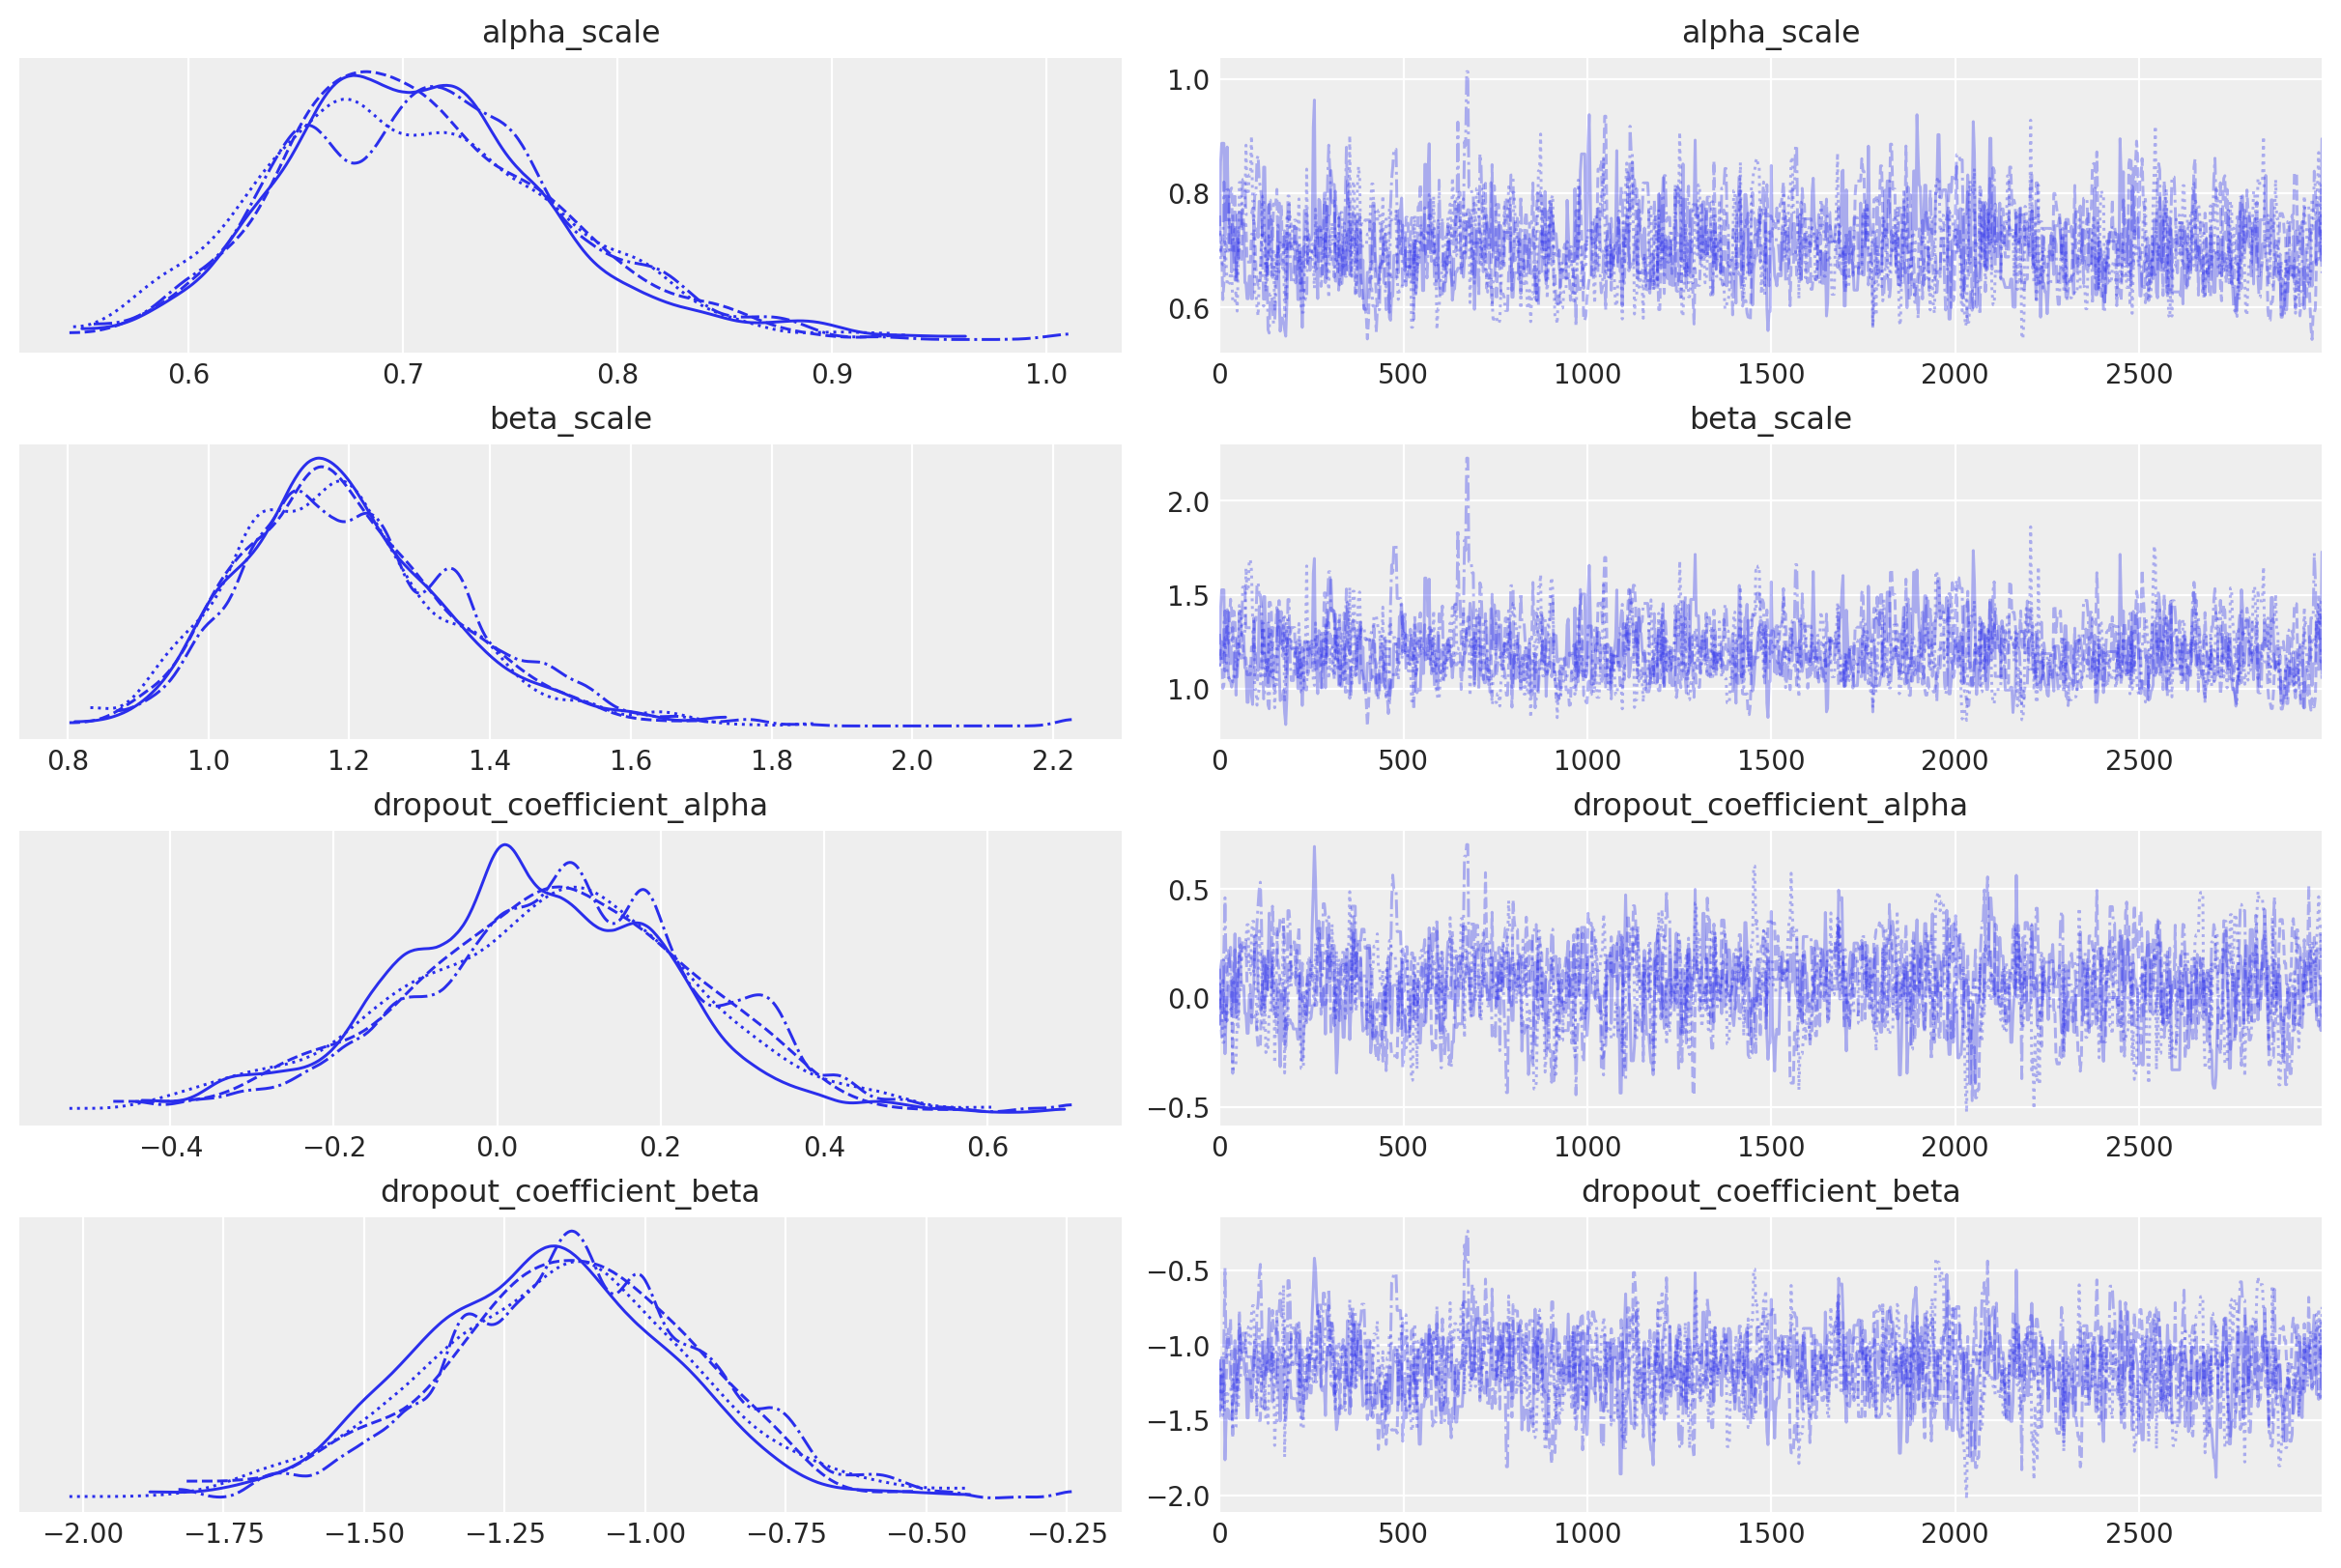

In [24]:
az.plot_trace(
    sbg_covar.idata,
    var_names=[
        "alpha_scale",
        "beta_scale",
        "dropout_coefficient_alpha",
        "dropout_coefficient_beta",
    ],
);

`alpha_scale` and `beta_scale` are baseline posteriors for each cohort, and the `dropout_coefficient` posteriors represent covariate effects across the entire customer population.

In this simple example with a single cohort ("population") and binary covariate variable ("highend customer"), we can see the mean impact of this covariate on `alpha` is near-zero, but the impact on `beta` is significantly higher.

Recall the mean of the Beta distribution:

$$E(\theta) = \frac{\alpha}{\alpha + \beta}$$

The negatively-valued posterior indicates `beta` will *increase* for each highend customer, and reduce the dropout expectation.

Cohort and covariate parameters are broadcasted together to create `alpha` and `beta` parameter pairs for every `customer id`:

In [25]:
sbg_covar.fit_summary(var_names=["alpha", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[1]    0.671  0.107   0.481    0.872      0.004    0.003     863.0   
alpha[2]    0.671  0.107   0.481    0.872      0.004    0.003     863.0   
alpha[3]    0.671  0.107   0.481    0.872      0.004    0.003     863.0   
alpha[4]    0.671  0.107   0.481    0.872      0.004    0.003     863.0   
alpha[5]    0.671  0.107   0.481    0.872      0.004    0.003     863.0   
...           ...    ...     ...      ...        ...      ...       ...   
beta[1996]  1.197  0.155   0.921    1.484      0.005    0.005     894.0   
beta[1997]  1.197  0.155   0.921    1.484      0.005    0.005     894.0   
beta[1998]  1.197  0.155   0.921    1.484      0.005    0.005     894.0   
beta[1999]  1.197  0.155   0.921    1.484      0.005    0.005     894.0   
beta[2000]  1.197  0.155   0.921    1.484      0.005    0.005     894.0   

            ess_tail  r_hat  
alpha[1]      1106.0   1.01  
alpha[2]      1106.0   1.01  
alpha[3]      1106.0   1.01  
alpha[4]      1106.0   1.01  
alpha[5]      1106.0   1.01  
...              ...    ...  
beta[1996]    1096.0   1.00  
beta[1997]    1096.0   1.00  
beta[1998]    1096.0   1.00  
beta[1999]    1096.0   1.00  
beta[2000]    1096.0   1.00  

[4000 rows x 9 columns]

### Reproduce Research with Covariates
To compare covariate `alpha` and `beta` estimates to the original research, we can use `customer_id` to extract parameters for known highend and regular customers:

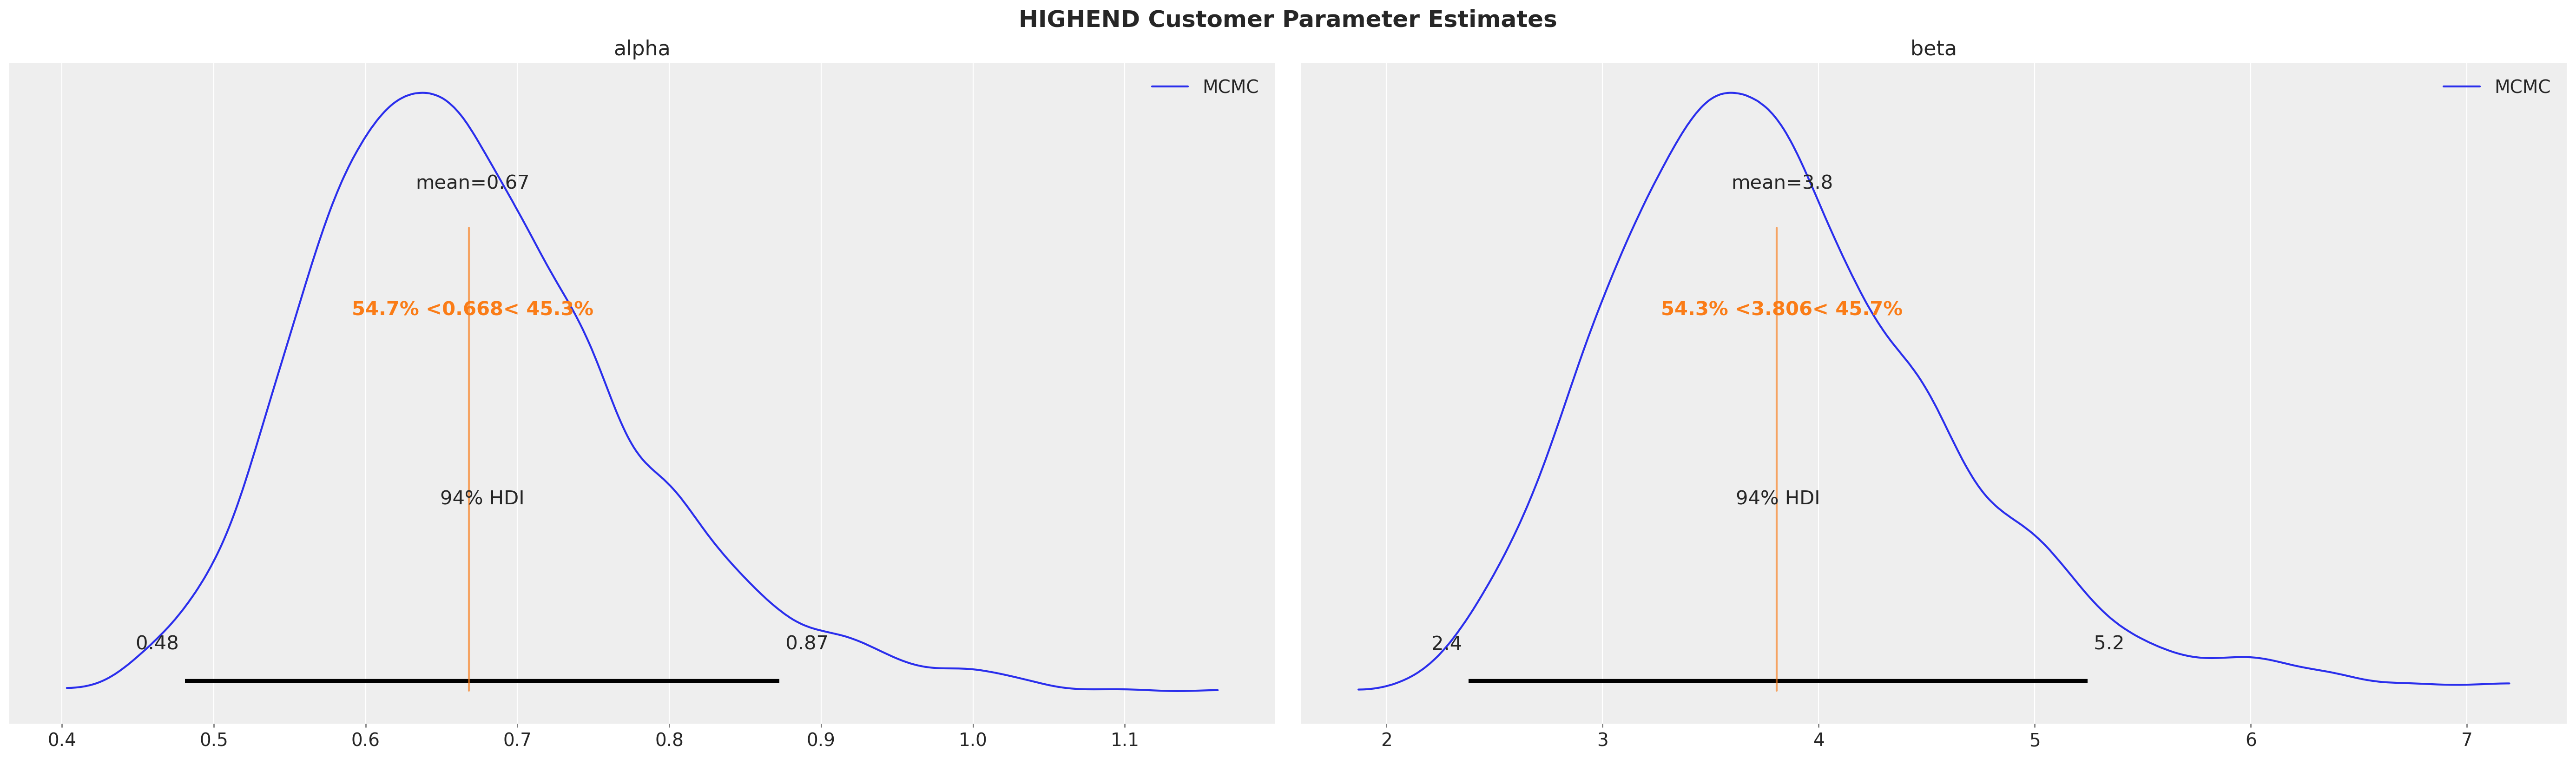

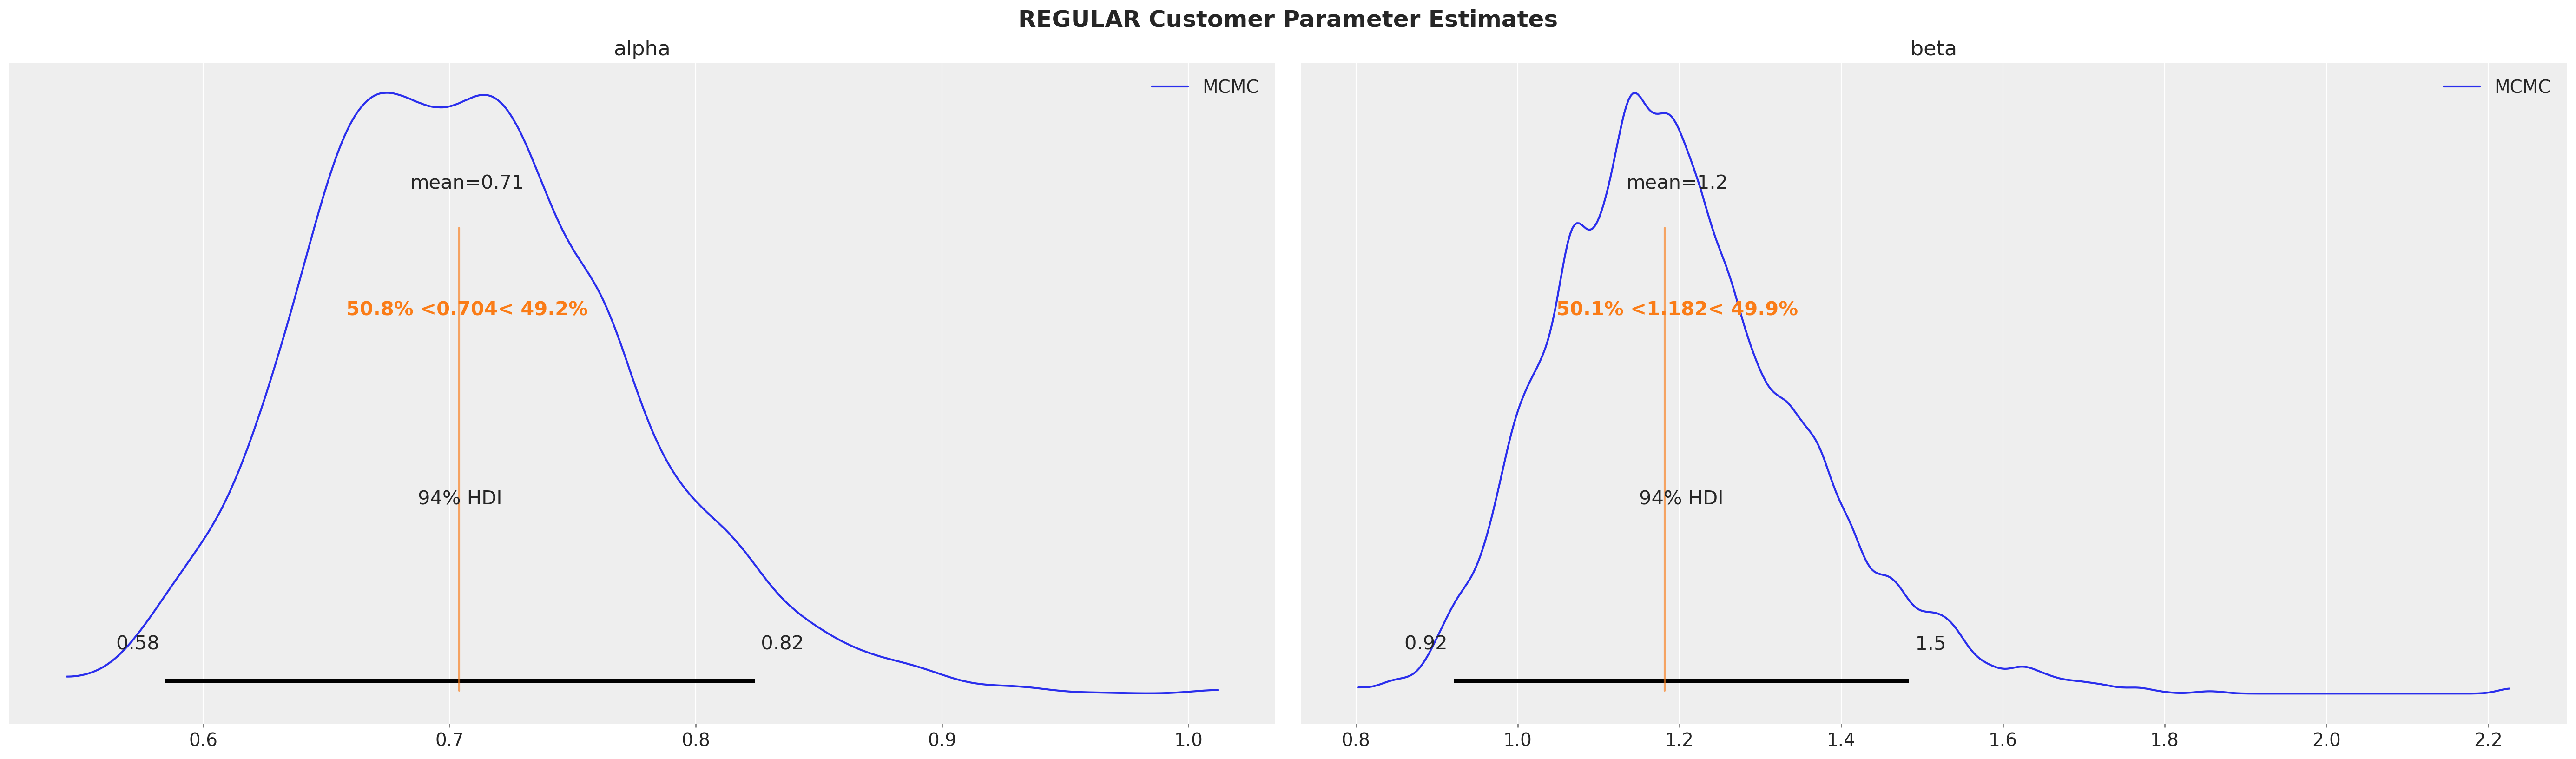

In [26]:
covariate_customer_ids = {
    "highend": 1,
    "regular": 2000,
}

for cohort, customer_id in covariate_customer_ids.items():
    az.plot_posterior(
        sbg_covar.idata.sel(customer_id=customer_id),
        var_names=["alpha", "beta"],
        ref_val=mle_research_parameters[cohort],
        label="MCMC",
    )
    plt.gcf().suptitle(
        f"{cohort.upper()} Customer Parameter Estimates", fontsize=18, fontweight="bold"
    )

Parameter estimates are equivalent regardless if segments are specified by cohort or covariate!

# End-to-End Example with Cohorts and Covariates

## Simulate Data
Let's expand the previous covariate dataframe to create a monthly cohort dataset that also includes the same covariates:

In [27]:
# Use covariate_df to generate 7 monthly cohorts
cohort_dfs = []

for month in range(1, 8):
    # Calculate observation period: January (month 1) has 8 periods, July (month 7) has 2 periods
    observation_periods = 9 - month  # 8 for month 1, 7 for month 2, ..., 2 for month 7
    month_cohort_name = f"2025-{month:02d}"

    # Copy the covariate data
    monthly_cohort_df = covariate_df.copy()

    # Truncate recency to the observation period
    # If a customer churned after the observation period, they appear alive at T
    monthly_cohort_df["recency"] = monthly_cohort_df["recency"].clip(
        upper=observation_periods
    )

    # Update T to the correct observation period for this cohort
    monthly_cohort_df["T"] = observation_periods

    # Add the time-based cohort (month they joined)
    monthly_cohort_df["cohort"] = month_cohort_name

    cohort_dfs.append(monthly_cohort_df)

# Combine all monthly cohorts
monthly_cohort_dataset = pd.concat(cohort_dfs, ignore_index=True)

# Recreate customer_id to be unique across all cohorts
monthly_cohort_dataset["customer_id"] = monthly_cohort_dataset.index + 1

# Reorder columns
monthly_cohort_dataset = monthly_cohort_dataset[
    [
        "customer_id",
        "recency",
        "T",
        "cohort",
        "highend_customer",
    ]
]

print(f"\nMonthly cohorts: {sorted(monthly_cohort_dataset['cohort'].unique())}")

monthly_cohort_dataset


Monthly cohorts: ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07']


customer_id  recency  T   cohort  highend_customer
0                1        1  8  2025-01                 1
1                2        1  8  2025-01                 1
2                3        1  8  2025-01                 1
3                4        1  8  2025-01                 1
4                5        1  8  2025-01                 1
...            ...      ... ..      ...               ...
13995        13996        2  2  2025-07                 0
13996        13997        2  2  2025-07                 0
13997        13998        2  2  2025-07                 0
13998        13999        2  2  2025-07                 0
13999        14000        2  2  2025-07                 0

[14000 rows x 5 columns]

A cohort chart is useful to see how cohorts compare in size and retention, revealing seasonality and growth trends:

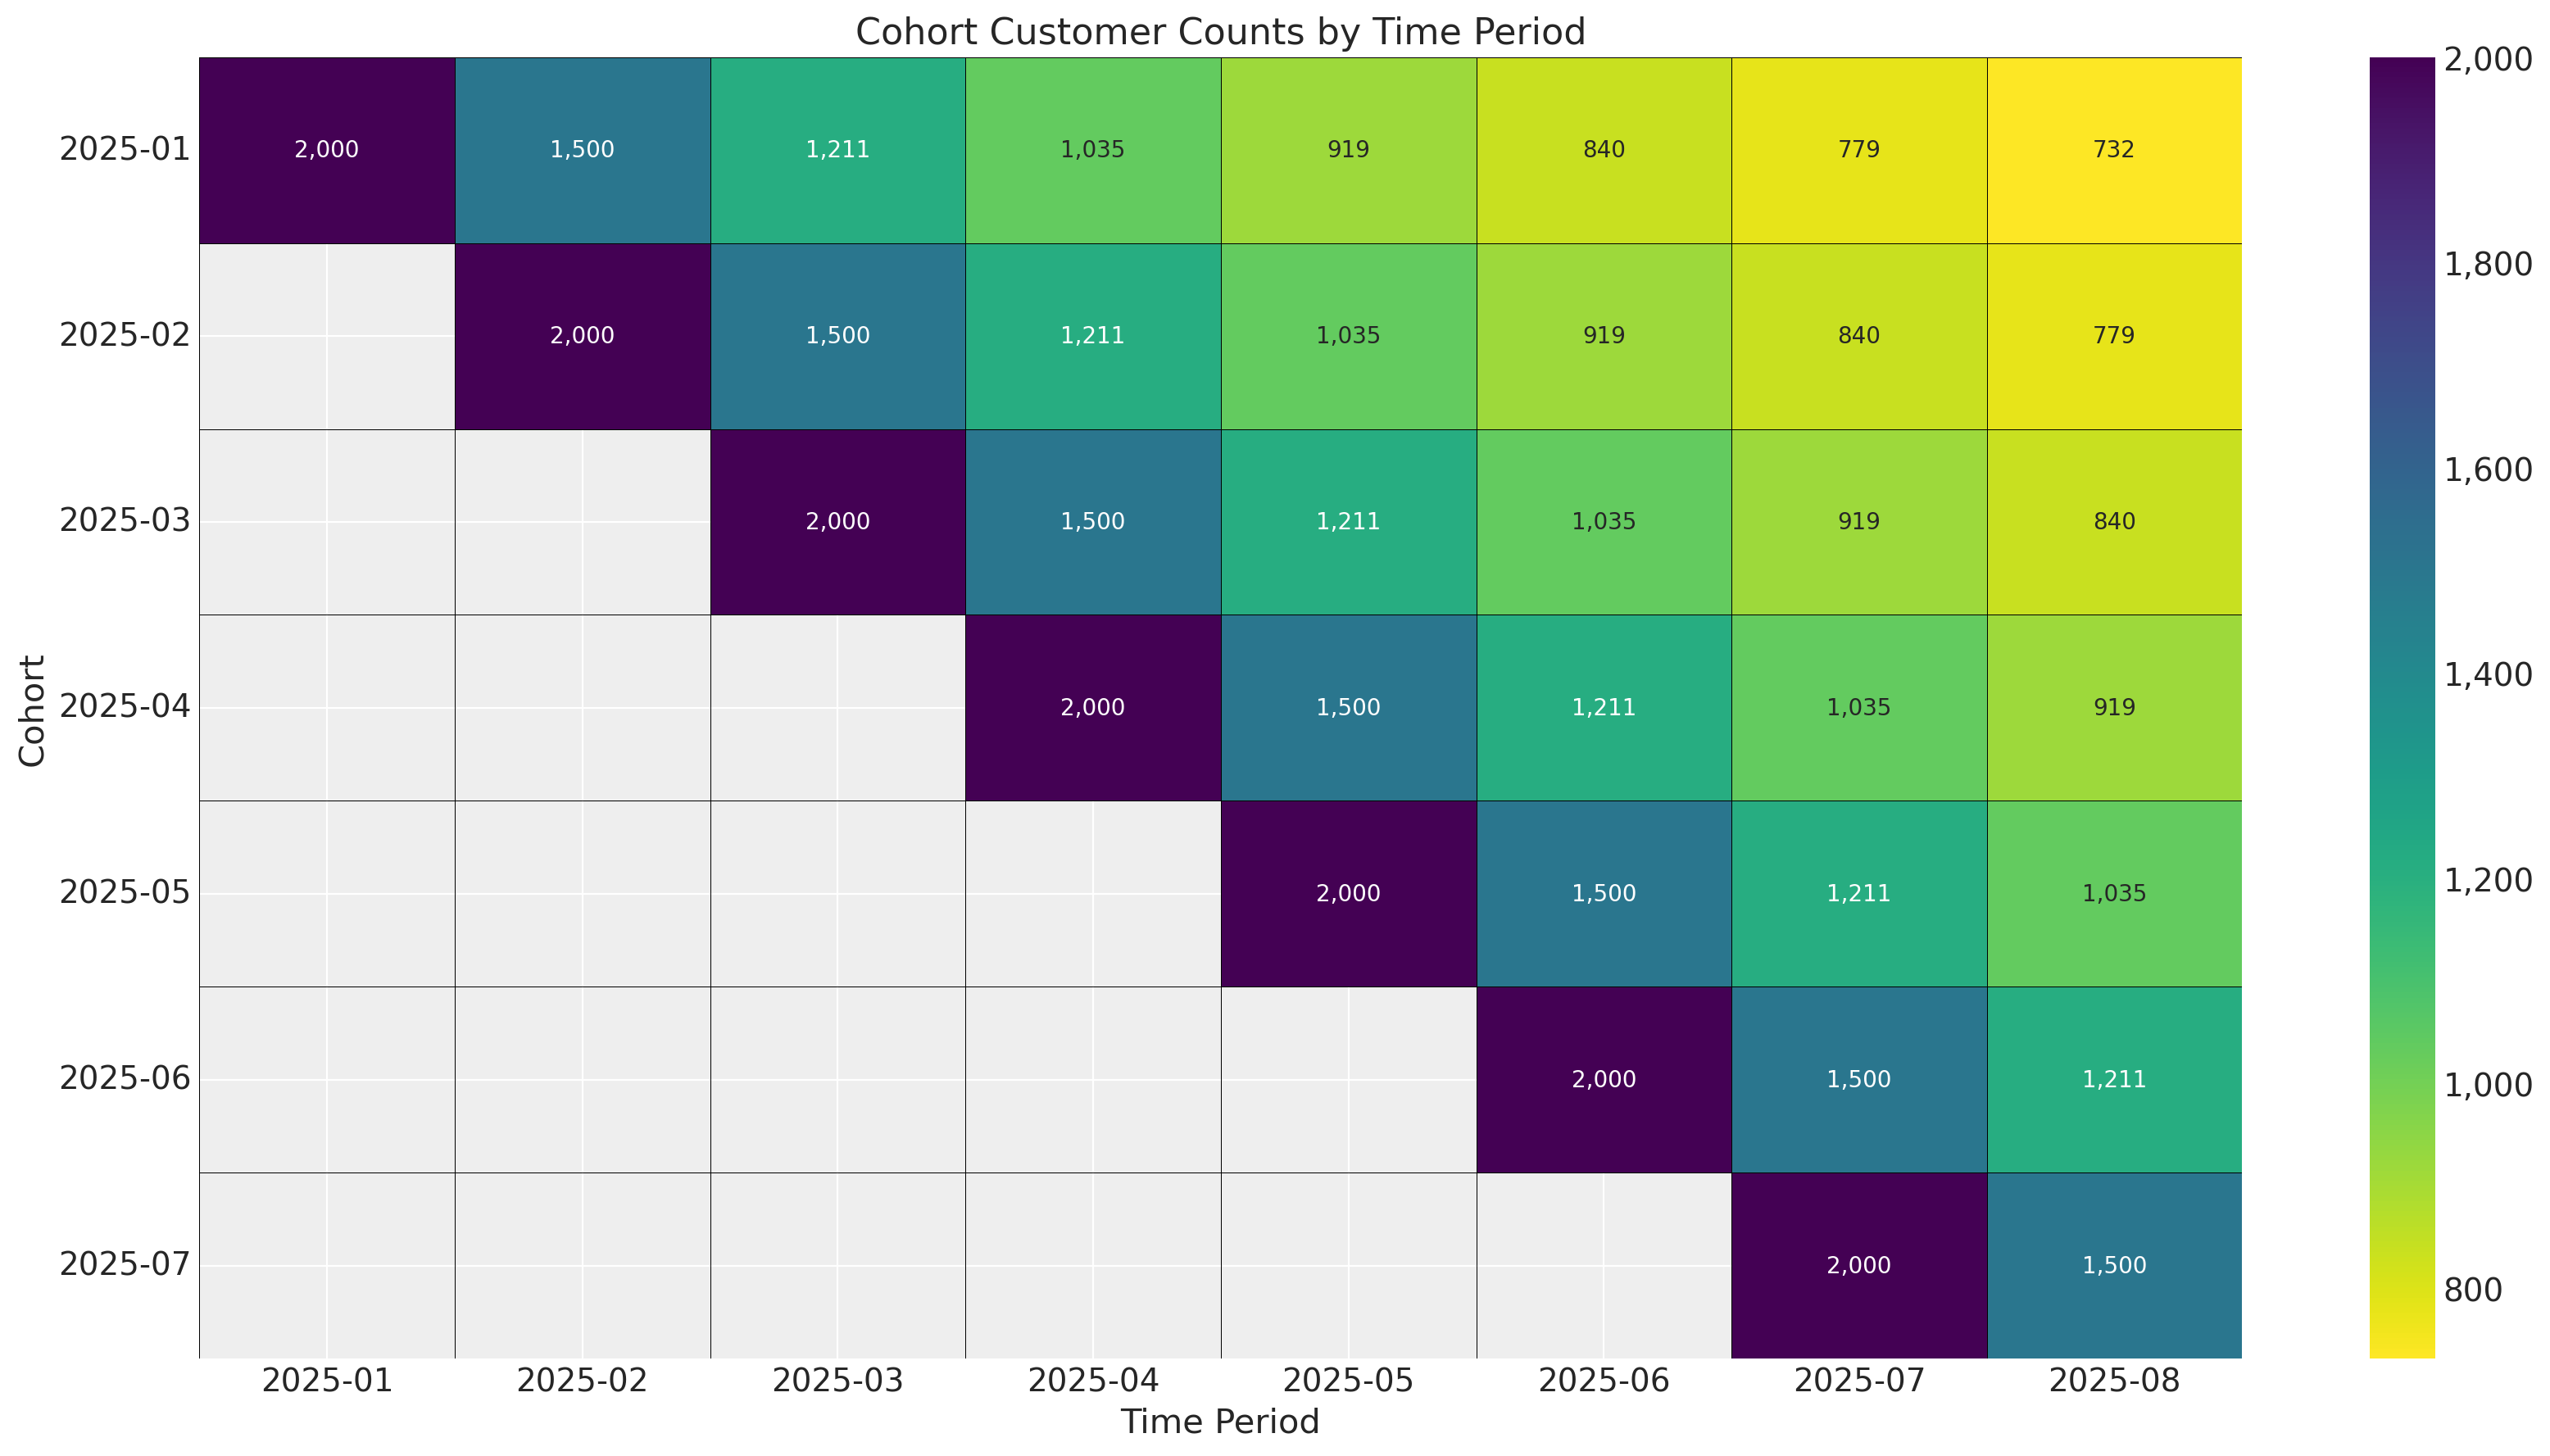

In [ ]:
def pivot_sbg_cohort_data(customer_df: pd.DataFrame) -> pd.DataFrame:
    """Create a cohort chart from ShiftedBetaGeoModel modeling data.

    Transform modeling data into an upper triangular cohort chart
    with labeled time periods.

    Parameters
    ----------
    customer_df : pd.DataFrame
        DataFrame with columns: customer_id, recency, T, cohort
        Cohort should be in YYYY-MM format

    Returns
    -------
    pd.DataFrame
        Pivoted DataFrame with cohorts as index, calendar periods as columns

    """
    results = []

    for cohort in customer_df["cohort"].unique():
        cohort_df = customer_df[customer_df["cohort"] == cohort]
        max_t_cohort = cohort_df["T"].iloc[0]

        # Parse cohort date
        cohort_date = pd.to_datetime(cohort)

        # Calculate retention for each relative period (age)
        for age in range(max_t_cohort):
            # Calculate absolute calendar period (cohort_date + age months)
            period = cohort_date + relativedelta(months=age)
            period_str = period.strftime("%Y-%m")

            # Calculate number of surviving customers
            survived = (cohort_df["recency"] > age).sum().astype(np.int64)

            results.append(
                {
                    "cohort": cohort,
                    "period": period_str,
                    "cohort_age": age,
                    "retention": survived,
                }
            )

    # Pivot to get cohorts as rows, calendar periods as columns
    pivot_df = pd.DataFrame(results).pivot(
        index="cohort", columns="period", values="retention"
    )

    # Sort index (cohorts) and columns (periods) chronologically
    pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df[sorted(pivot_df.columns)]

    return pivot_df


# Create pivoted data
cohort_pivot = pivot_sbg_cohort_data(monthly_cohort_dataset)

plt.rcParams["figure.constrained_layout.use"] = False

# Plot cohort chart as a heatmap
fig, ax = plt.subplots(figsize=(17, 9))

sb.heatmap(
    cohort_pivot,
    cmap="viridis_r",
    linewidths=0.2,
    linecolor="black",
    annot=True,
    fmt=",.0f",
    cbar_kws={"format": mtick.FuncFormatter(func=lambda y, _: f"{y:,.0f}")},
    ax=ax,
)

# Rotate y-axis labels to horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.set_title("Cohort Customer Counts by Time Period")
ax.set_ylabel("Cohort")
ax.set_xlabel("Time Period")

plt.tight_layout()
plt.show()

In this example there are no external time-varying effects on retention because we simply shifted the survival curve one period forward for each cohort. In practice there will always be seasonality and events like holidays influencing retention. Since we are estimating a parameter set for each starting time period, we can control for time-varying factors!

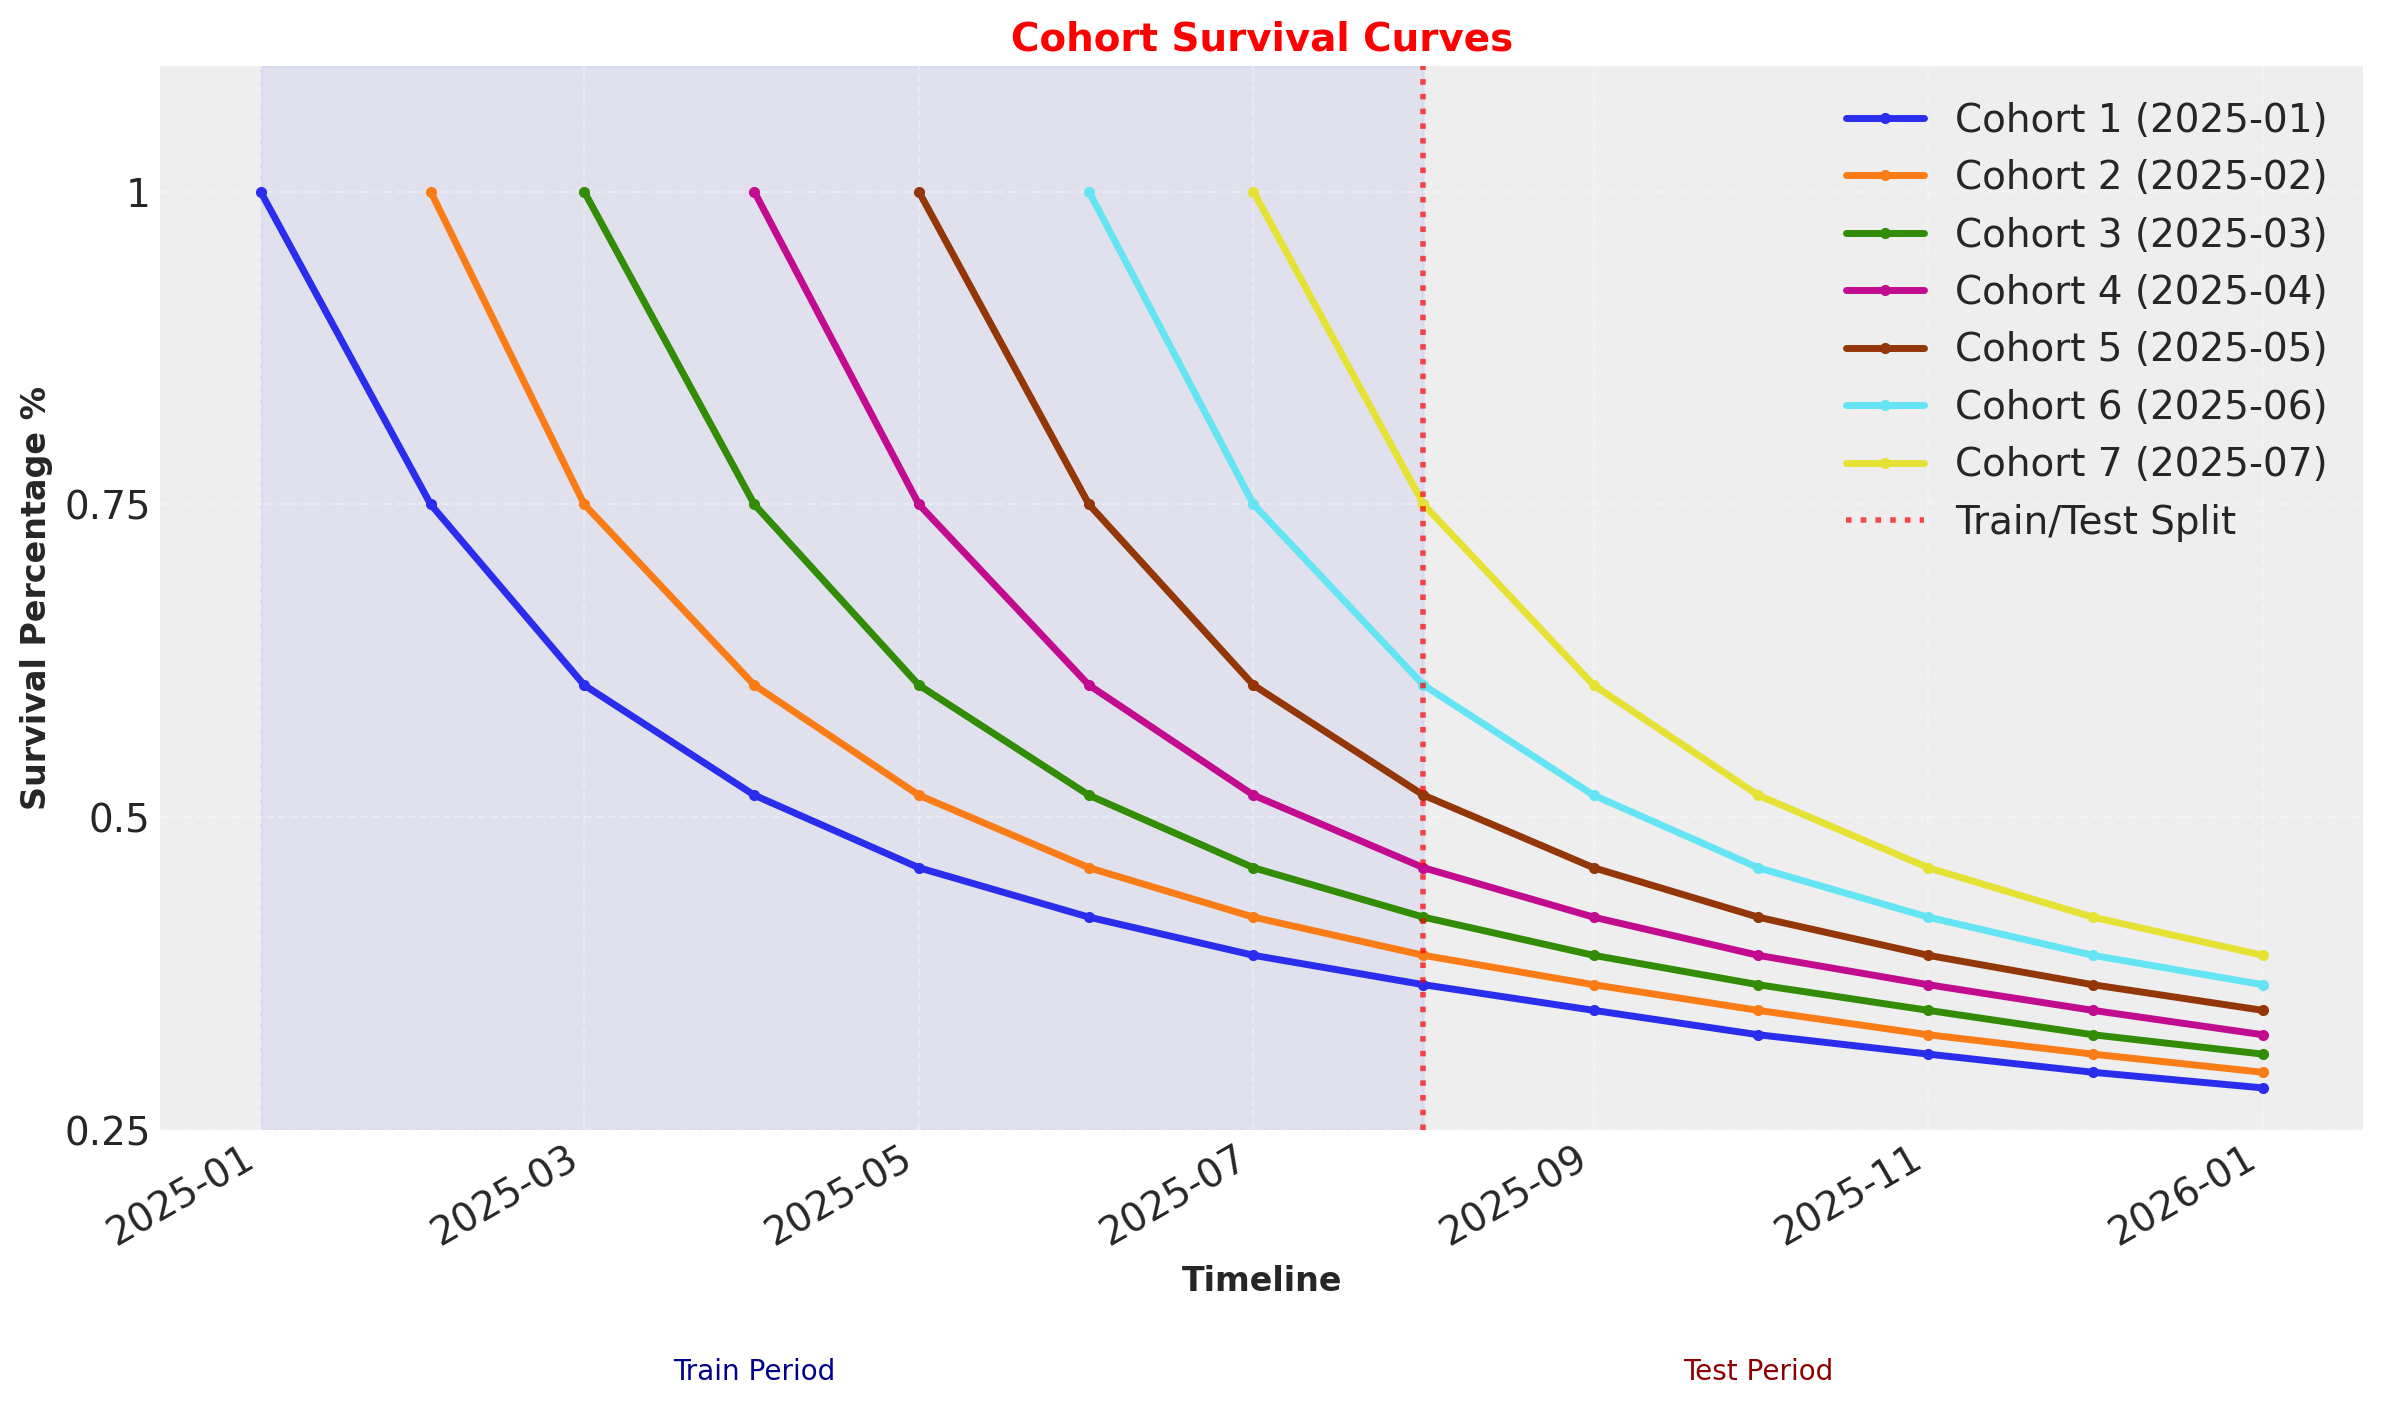

In [29]:
# Base survival curve (same pattern for all cohorts)
base_survival = research_data[["regular", "highend"]].values.mean(axis=1) / 100

# Create figure
fig, ax = plt.subplots(figsize=(12, 7))

# Define cohort start dates
cohort_start_dates = sorted(monthly_cohort_dataset["cohort"].unique())

# Plot each cohort
for i, cohort_date in enumerate(cohort_start_dates):
    # Calculate how many periods this cohort has been observed
    # Later cohorts have fewer observed periods
    observed_periods = len(base_survival) - i

    # Get survival data for this cohort
    cohort_survival = base_survival[:observed_periods]

    # Create timeline for this cohort (absolute dates)
    cohort_start = pd.to_datetime(cohort_date)
    cohort_timeline = [
        cohort_start + relativedelta(months=j) for j in range(observed_periods)
    ]

    # Plot the survival curve
    ax.plot(
        cohort_timeline,
        cohort_survival,
        linewidth=2.5,
        marker="o",
        markersize=3,
        label=f"Cohort {i + 1} ({cohort_date})",
    )

# Add vertical line separating train/test periods
train_end_date = pd.to_datetime("2025-08")
ax.axvline(
    train_end_date,
    linestyle=":",
    color="red",
    linewidth=2,
    alpha=0.7,
    label="Train/Test Split",
)

# Add shaded regions for train and test periods
ax.axvspan(
    pd.to_datetime("2025-01"), train_end_date, alpha=0.05, color="blue", zorder=0
)
ax.text(
    pd.to_datetime("2025-04"),
    0.05,
    "Train Period",
    ha="center",
    fontsize=10,
    color="darkblue",
)

# Add test period label
test_end_date = pd.to_datetime("2026-06")
ax.text(
    pd.to_datetime("2025-10"),
    0.05,
    "Test Period",
    ha="center",
    fontsize=10,
    color="darkred",
)

# Formatting
ax.set_xlabel("Timeline", fontsize=12, fontweight="bold")
ax.set_ylabel("Survival Percentage %", fontsize=12, fontweight="bold")
ax.set_title("Cohort Survival Curves", fontsize=14, fontweight="bold", color="red")

# Set y-axis limits
ax.set_ylim(0.25, 1.1)

# Format y-axis as percentage
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0.25", "0.5", "0.75", "1"])

# Format x-axis dates
ax.tick_params(axis="x", rotation=45)
fig.autofmt_xdate()

# Add legend
ax.legend(loc="upper right", framealpha=0.9)

# Add grid
ax.grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

These survival rates are the average of the Highend and Regular customer segments, which are indicated by covariates.

### Cohort + Covariate Model Fitting and Diagnostics

`DEMEtropolisZ` works well for covariates, but covergence is more difficult when dealing with multiple cohorts. For large datasets with millions of customers and dozens of cohorts, MAP fits may be the more practical choice. Regardless of the fit method used, multidimensional models often require well-defined priors - priors that are too broad may diverge, and if too narrow can overfit. For more information on prior elicitation see the [`preliz`](https://preliz.readthedocs.io/en/latest/index.html) library, as well as the [Prior Configuration](https://www.pymc-marketing.io/en/stable/notebooks/general/model_configuration.html#prior-distributions) section of the Model Configuration Notebook.

For this last example we will be using the default model config with the external `nutpie` sampler, which is written in rust and can run on GPUs.

In [ ]:
sbg_cohort = clv.ShiftedBetaGeoModel(
    model_config={
        "dropout_covariate_cols": ["highend_customer"],
    },
)
sbg_cohort.fit(
    data=monthly_cohort_dataset, method="mcmc", nuts_sampler="nutpie", random_seed=rng
)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

Warmup iterations saved (warmup_*).

In [31]:
sbg_cohort.fit_summary(
    var_names=[
        "alpha_scale",
        "beta_scale",
        "dropout_coefficient_alpha",
        "dropout_coefficient_beta",
    ]
)

mean      sd  hdi_3%  hdi_97%  \
alpha_scale[2025-01]                         0.670   0.057   0.567    0.776   
alpha_scale[2025-02]                         0.700   0.066   0.576    0.824   
alpha_scale[2025-03]                         0.738   0.074   0.604    0.876   
alpha_scale[2025-04]                         0.795   0.094   0.627    0.966   
alpha_scale[2025-05]                         0.854   0.137   0.614    1.101   
alpha_scale[2025-06]                         1.007   0.299   0.586    1.545   
alpha_scale[2025-07]                         3.749  34.215   0.341    5.671   
beta_scale[2025-01]                          1.125   0.128   0.887    1.352   
beta_scale[2025-02]                          1.177   0.146   0.918    1.452   
beta_scale[2025-03]                          1.244   0.161   0.954    1.542   
beta_scale[2025-04]                          1.342   0.196   0.997    1.704   
beta_scale[2025-05]                          1.448   0.276   0.977    1.965   
beta_scale[2025-06]                          1.739   0.566   0.912    2.725   
beta_scale[2025-07]                          6.601  61.150   0.617   10.162   
dropout_coefficient_alpha[highend_customer] -0.172   0.112  -0.368    0.051   
dropout_coefficient_beta[highend_customer]  -1.428   0.132  -1.670   -1.175   

                                             mcse_mean  mcse_sd  ess_bulk  \
alpha_scale[2025-01]                             0.001    0.001    3615.0   
alpha_scale[2025-02]                             0.001    0.001    3633.0   
alpha_scale[2025-03]                             0.001    0.001    3809.0   
alpha_scale[2025-04]                             0.001    0.002    4007.0   
alpha_scale[2025-05]                             0.002    0.002    4185.0   
alpha_scale[2025-06]                             0.005    0.009    4845.0   
alpha_scale[2025-07]                             0.600    7.920    5479.0   
beta_scale[2025-01]                              0.002    0.002    3390.0   
beta_scale[2025-02]                              0.003    0.003    2910.0   
beta_scale[2025-03]                              0.003    0.003    3331.0   
beta_scale[2025-04]                              0.003    0.003    3574.0   
beta_scale[2025-05]                              0.004    0.005    3706.0   
beta_scale[2025-06]                              0.009    0.018    4453.0   
beta_scale[2025-07]                              1.064   14.775    5644.0   
dropout_coefficient_alpha[highend_customer]      0.003    0.002    1054.0   
dropout_coefficient_beta[highend_customer]       0.004    0.003    1030.0   

                                             ess_tail  r_hat  
alpha_scale[2025-01]                           2966.0    1.0  
alpha_scale[2025-02]                           3542.0    1.0  
alpha_scale[2025-03]                           2978.0    1.0  
alpha_scale[2025-04]                           2671.0    1.0  
alpha_scale[2025-05]                           3264.0    1.0  
alpha_scale[2025-06]                           2831.0    1.0  
alpha_scale[2025-07]                           2460.0    1.0  
beta_scale[2025-01]                            2809.0    1.0  
beta_scale[2025-02]                            2730.0    1.0  
beta_scale[2025-03]                            2498.0    1.0  
beta_scale[2025-04]                            2620.0    1.0  
beta_scale[2025-05]                            3144.0    1.0  
beta_scale[2025-06]                            2754.0    1.0  
beta_scale[2025-07]                            2340.0    1.0  
dropout_coefficient_alpha[highend_customer]    1416.0    1.0  
dropout_coefficient_beta[highend_customer]     1484.0    1.0

We can see from the fit summary the covariate posteriors are similar to the previous model, but cohort parameters shift towards larger values (and higher dropout probabilities) in later cohorts as observable training data decreases.

### Survival and Retention Plot Diagnostics

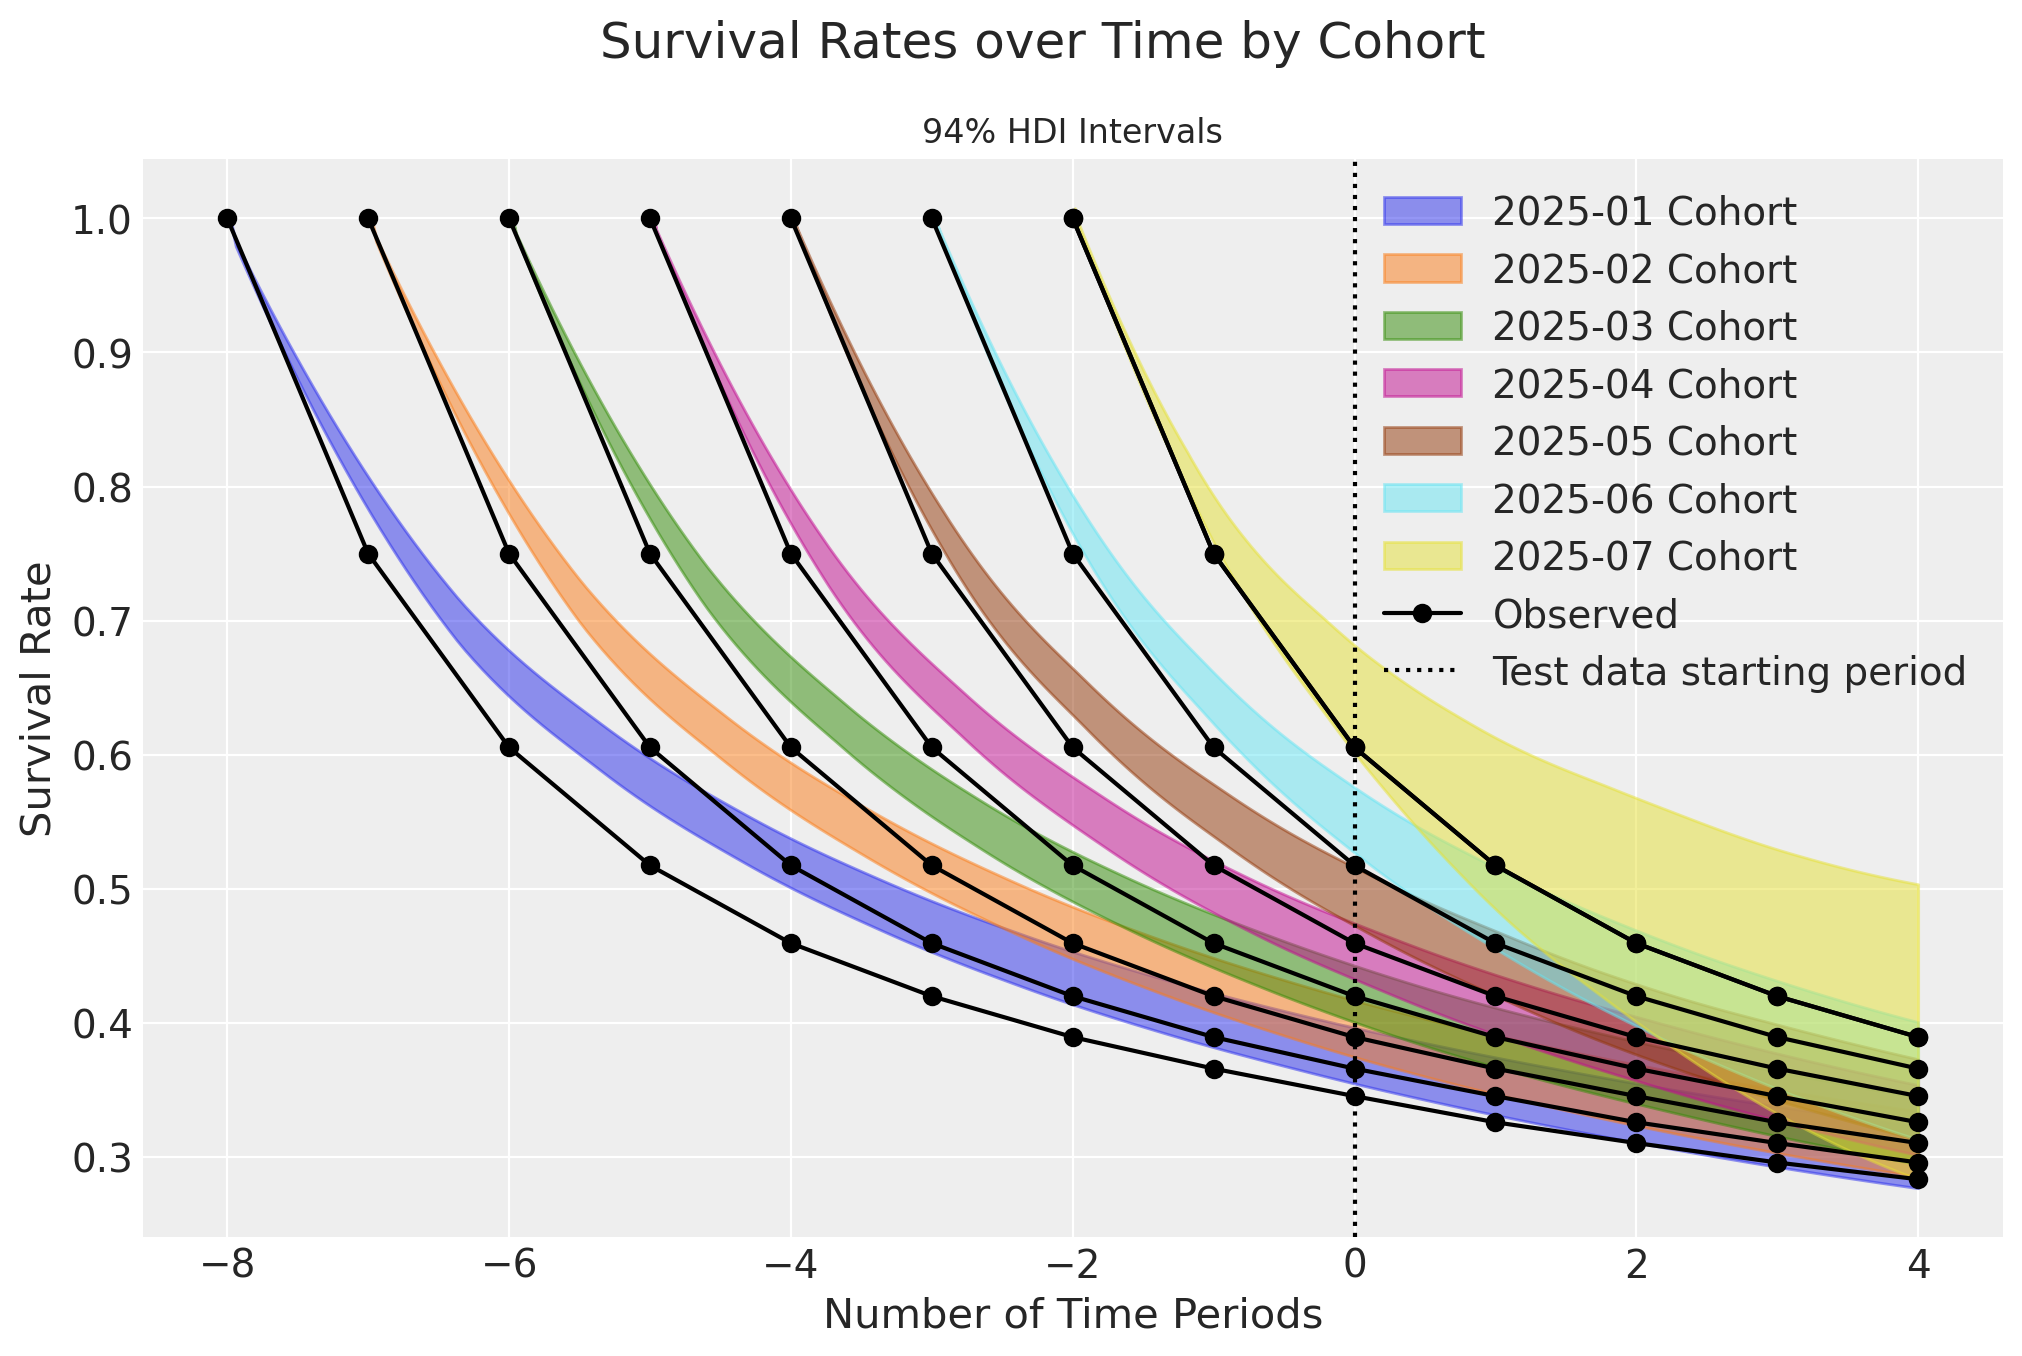

In [32]:
all_T = len(base_survival)
base_survival = research_data[["regular", "highend"]].values.mean(axis=1) / 100

for i, month in enumerate(cohort_start_dates):
    active_customers = monthly_cohort_dataset.query("recency==T").copy()
    single_cohort_df = active_customers[active_customers["cohort"] == month].copy()

    train_offset = i - 8
    offset_range = range(train_offset, all_T - i + train_offset)

    # Run predictions
    expected_survival_rates = xr.concat(
        objs=[
            sbg_cohort.expected_probability_alive(
                data=single_cohort_df,
                future_t=T,
            )
            for T in offset_range
        ],
        dim="T",
    ).transpose(..., "T")

    # Plot predictions per cohort
    az.plot_hdi(
        offset_range,
        expected_survival_rates.sel(cohort=month).mean("cohort"),
        hdi_prob=0.94,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.5, "label": f"{month} Cohort"},
    )
    # Plot observed survival curve, shifting T index for each cohort
    plt.plot(offset_range, base_survival[: all_T - i], marker="o", color="k")

# Plot the observed survival curve one more time to get a single label for the legend
plt.plot(
    offset_range, base_survival[: all_T - i], marker="o", color="k", label="Observed"
)
plt.axvline(0, ls=":", color="k", label="Test data starting period")
plt.legend()

plt.ylabel("Survival Rate")
plt.xlabel("Number of Time Periods")
plt.suptitle("Survival Rates over Time by Cohort", fontsize=18)
plt.title("94% HDI Intervals", fontsize=12);

There is clear bias in the survival plots over time. However, when plotted only for the current time period, an interesting story emerges:

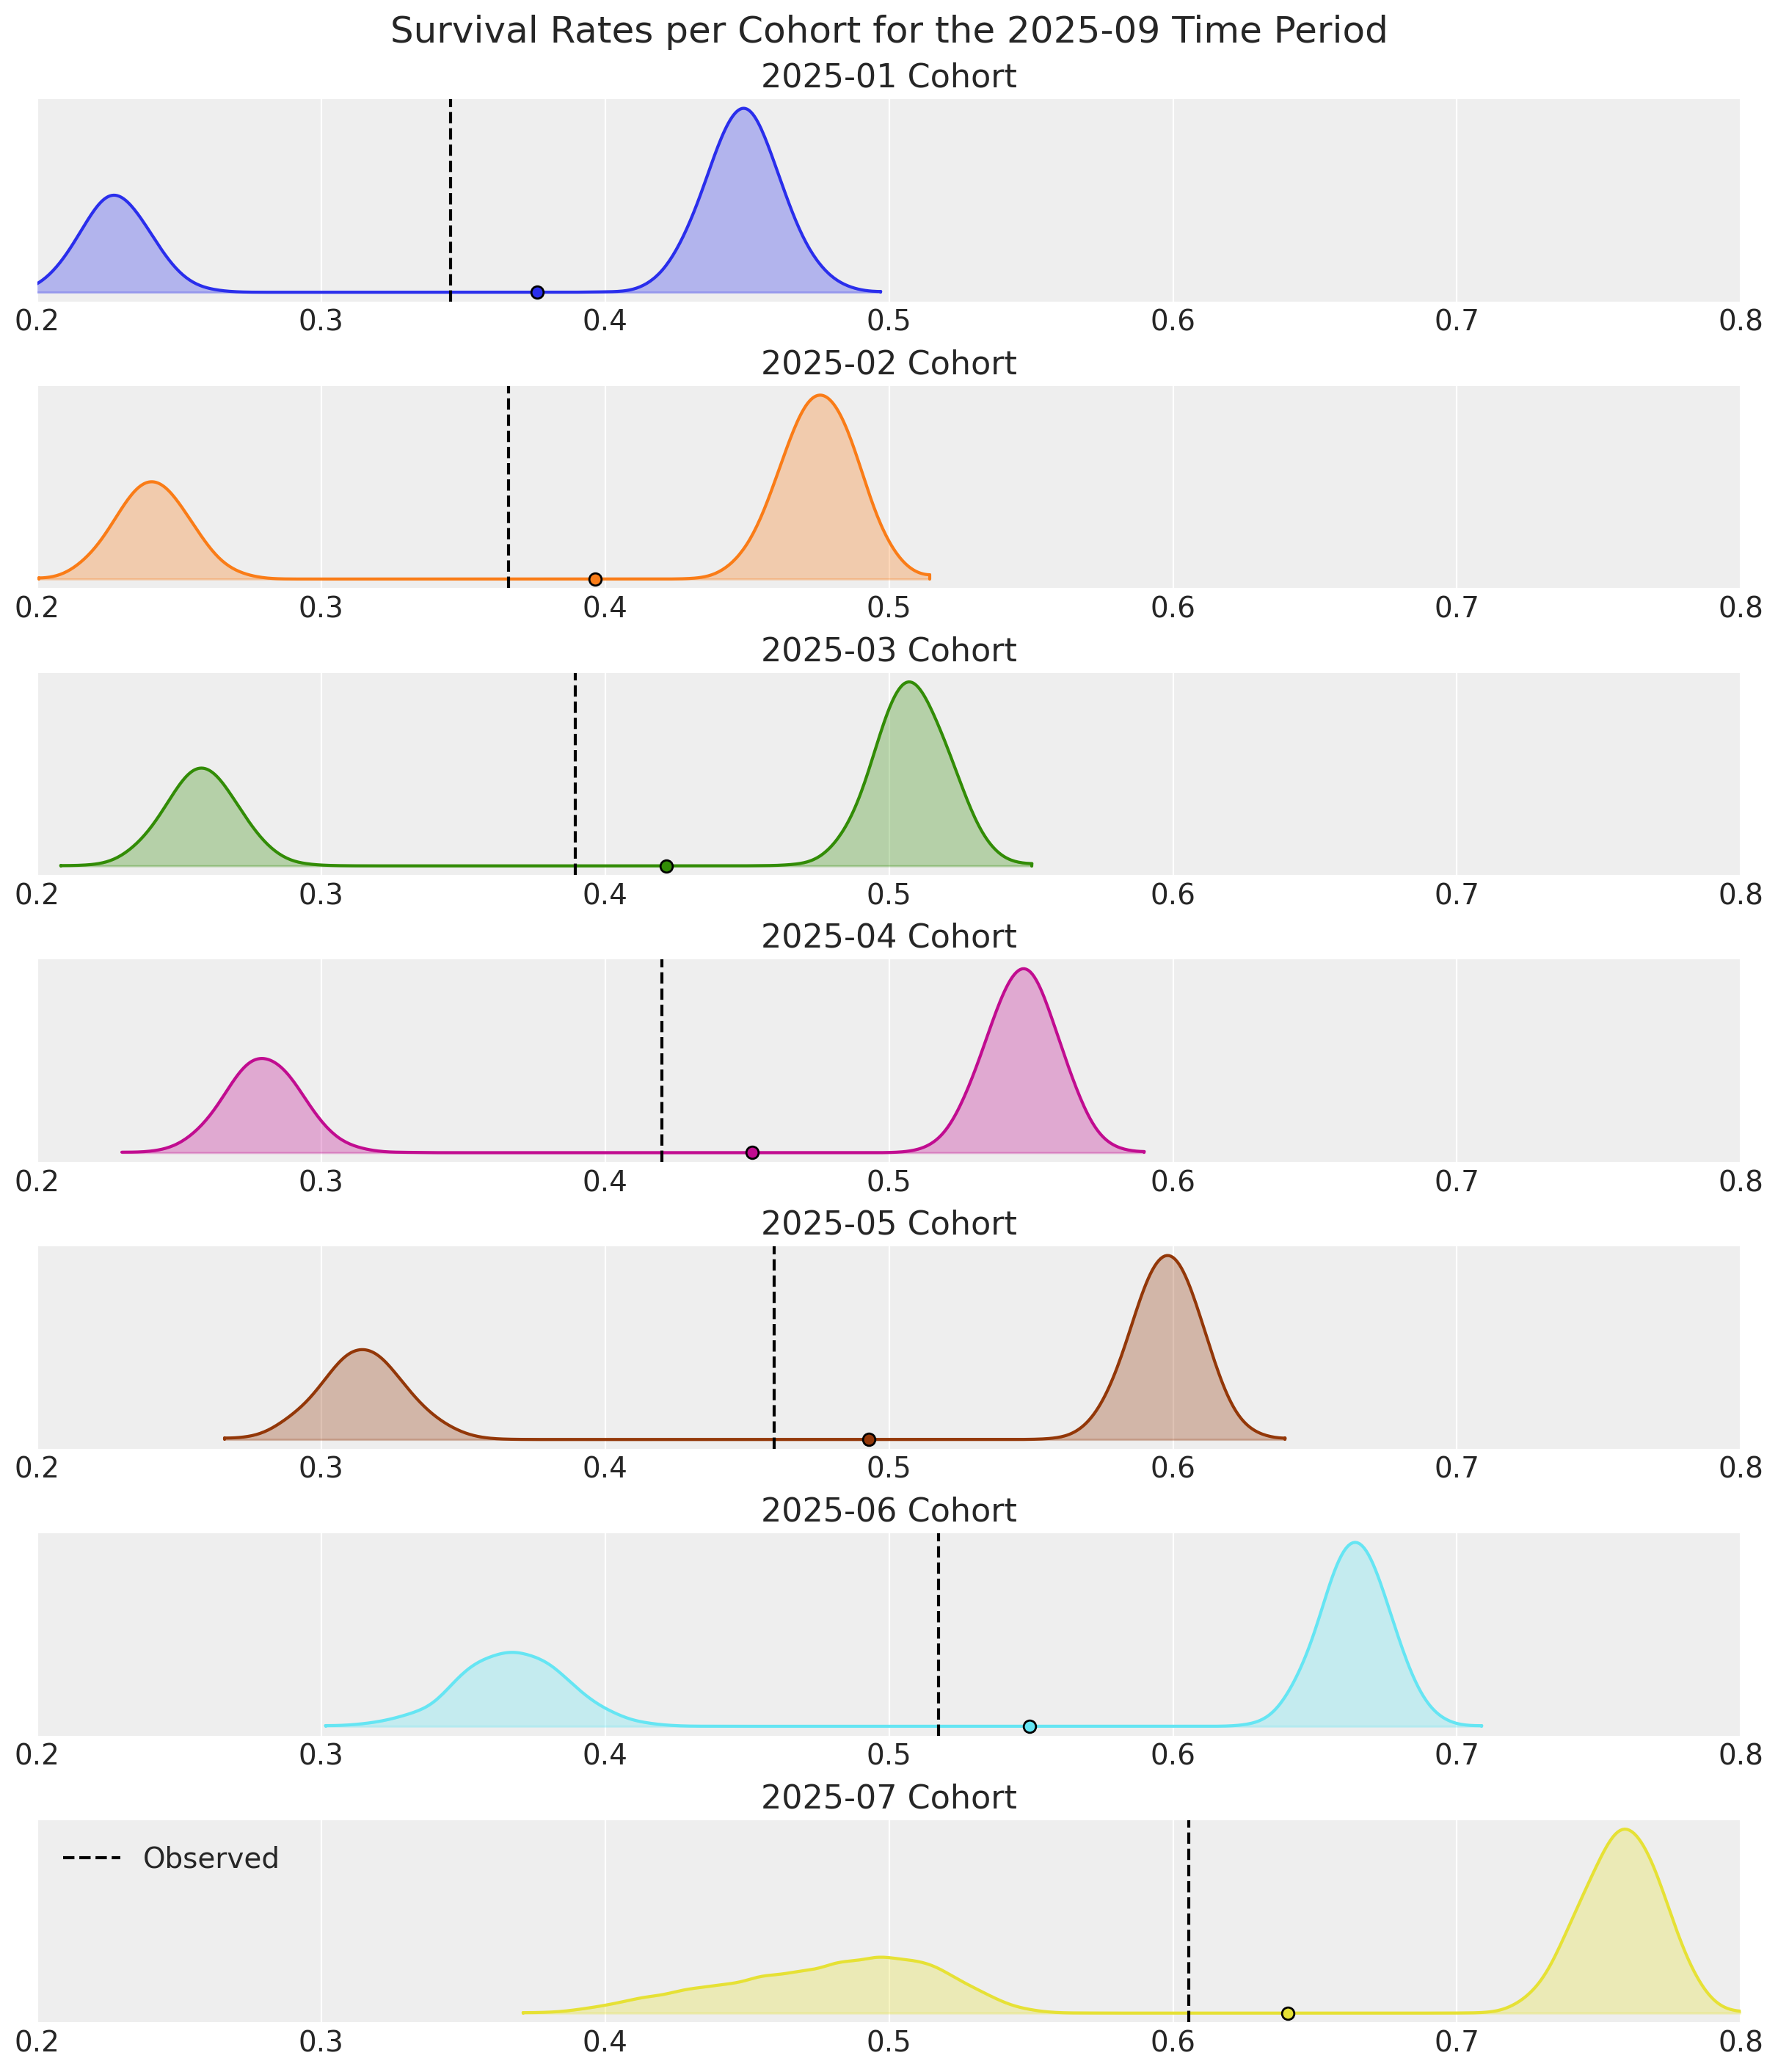

In [33]:
active_customers = monthly_cohort_dataset.query("recency==T").copy()

_, axes = plt.subplots(
    nrows=7,
    ncols=1,
    figsize=(12, 14),
    layout="constrained",
)

axes = axes.flatten()

for i, month in enumerate(cohort_start_dates):
    active_customers = monthly_cohort_dataset.query("recency==T").copy()
    active_monthly = active_customers[active_customers["cohort"] == month].copy()

    ax = axes[i]

    cohort_survival = sbg_cohort.expected_probability_alive(
        data=active_monthly,
        future_t=0,
    ).sel(cohort=month)

    az.plot_density(
        cohort_survival, hdi_prob=1, colors=f"C{i}", shade=0.3, bw=0.005, ax=ax
    )
    ax.axvline(x=base_survival[8 - i], color="k", linestyle="--", label="Observed")
    ax.set(
        title=f"{month} Cohort",
        xlim=[0.2, 0.8],
    )
plt.legend()
plt.gcf().suptitle(
    "Survival Rates per Cohort for the 2025-09 Time Period", fontsize=18
);

**Survival estimates are bi-modal for all cohorts!** This is due to earlier cohorts retaining an increasingly higher proportion of Highend customers over time. For later cohorts with shorter time durations, the observed survival rates shift towards Regular customers who cancel their contracts sooner. *The survival curves would look much better if filtered by covariate segment.*

Note the consistency in the highend customer densities. Information-sharing across cohorts is where hierarchical Bayesian models truly shine. The 2025-07 cohort would overfit with a dedicated Frequentist model, but when doing things the Bayesian way, we still have useful estimates for a cohort consisting of only 2 time periods and 25% non-censored customers!

A similar bi-modal pattern emerges when we look at retention rates:

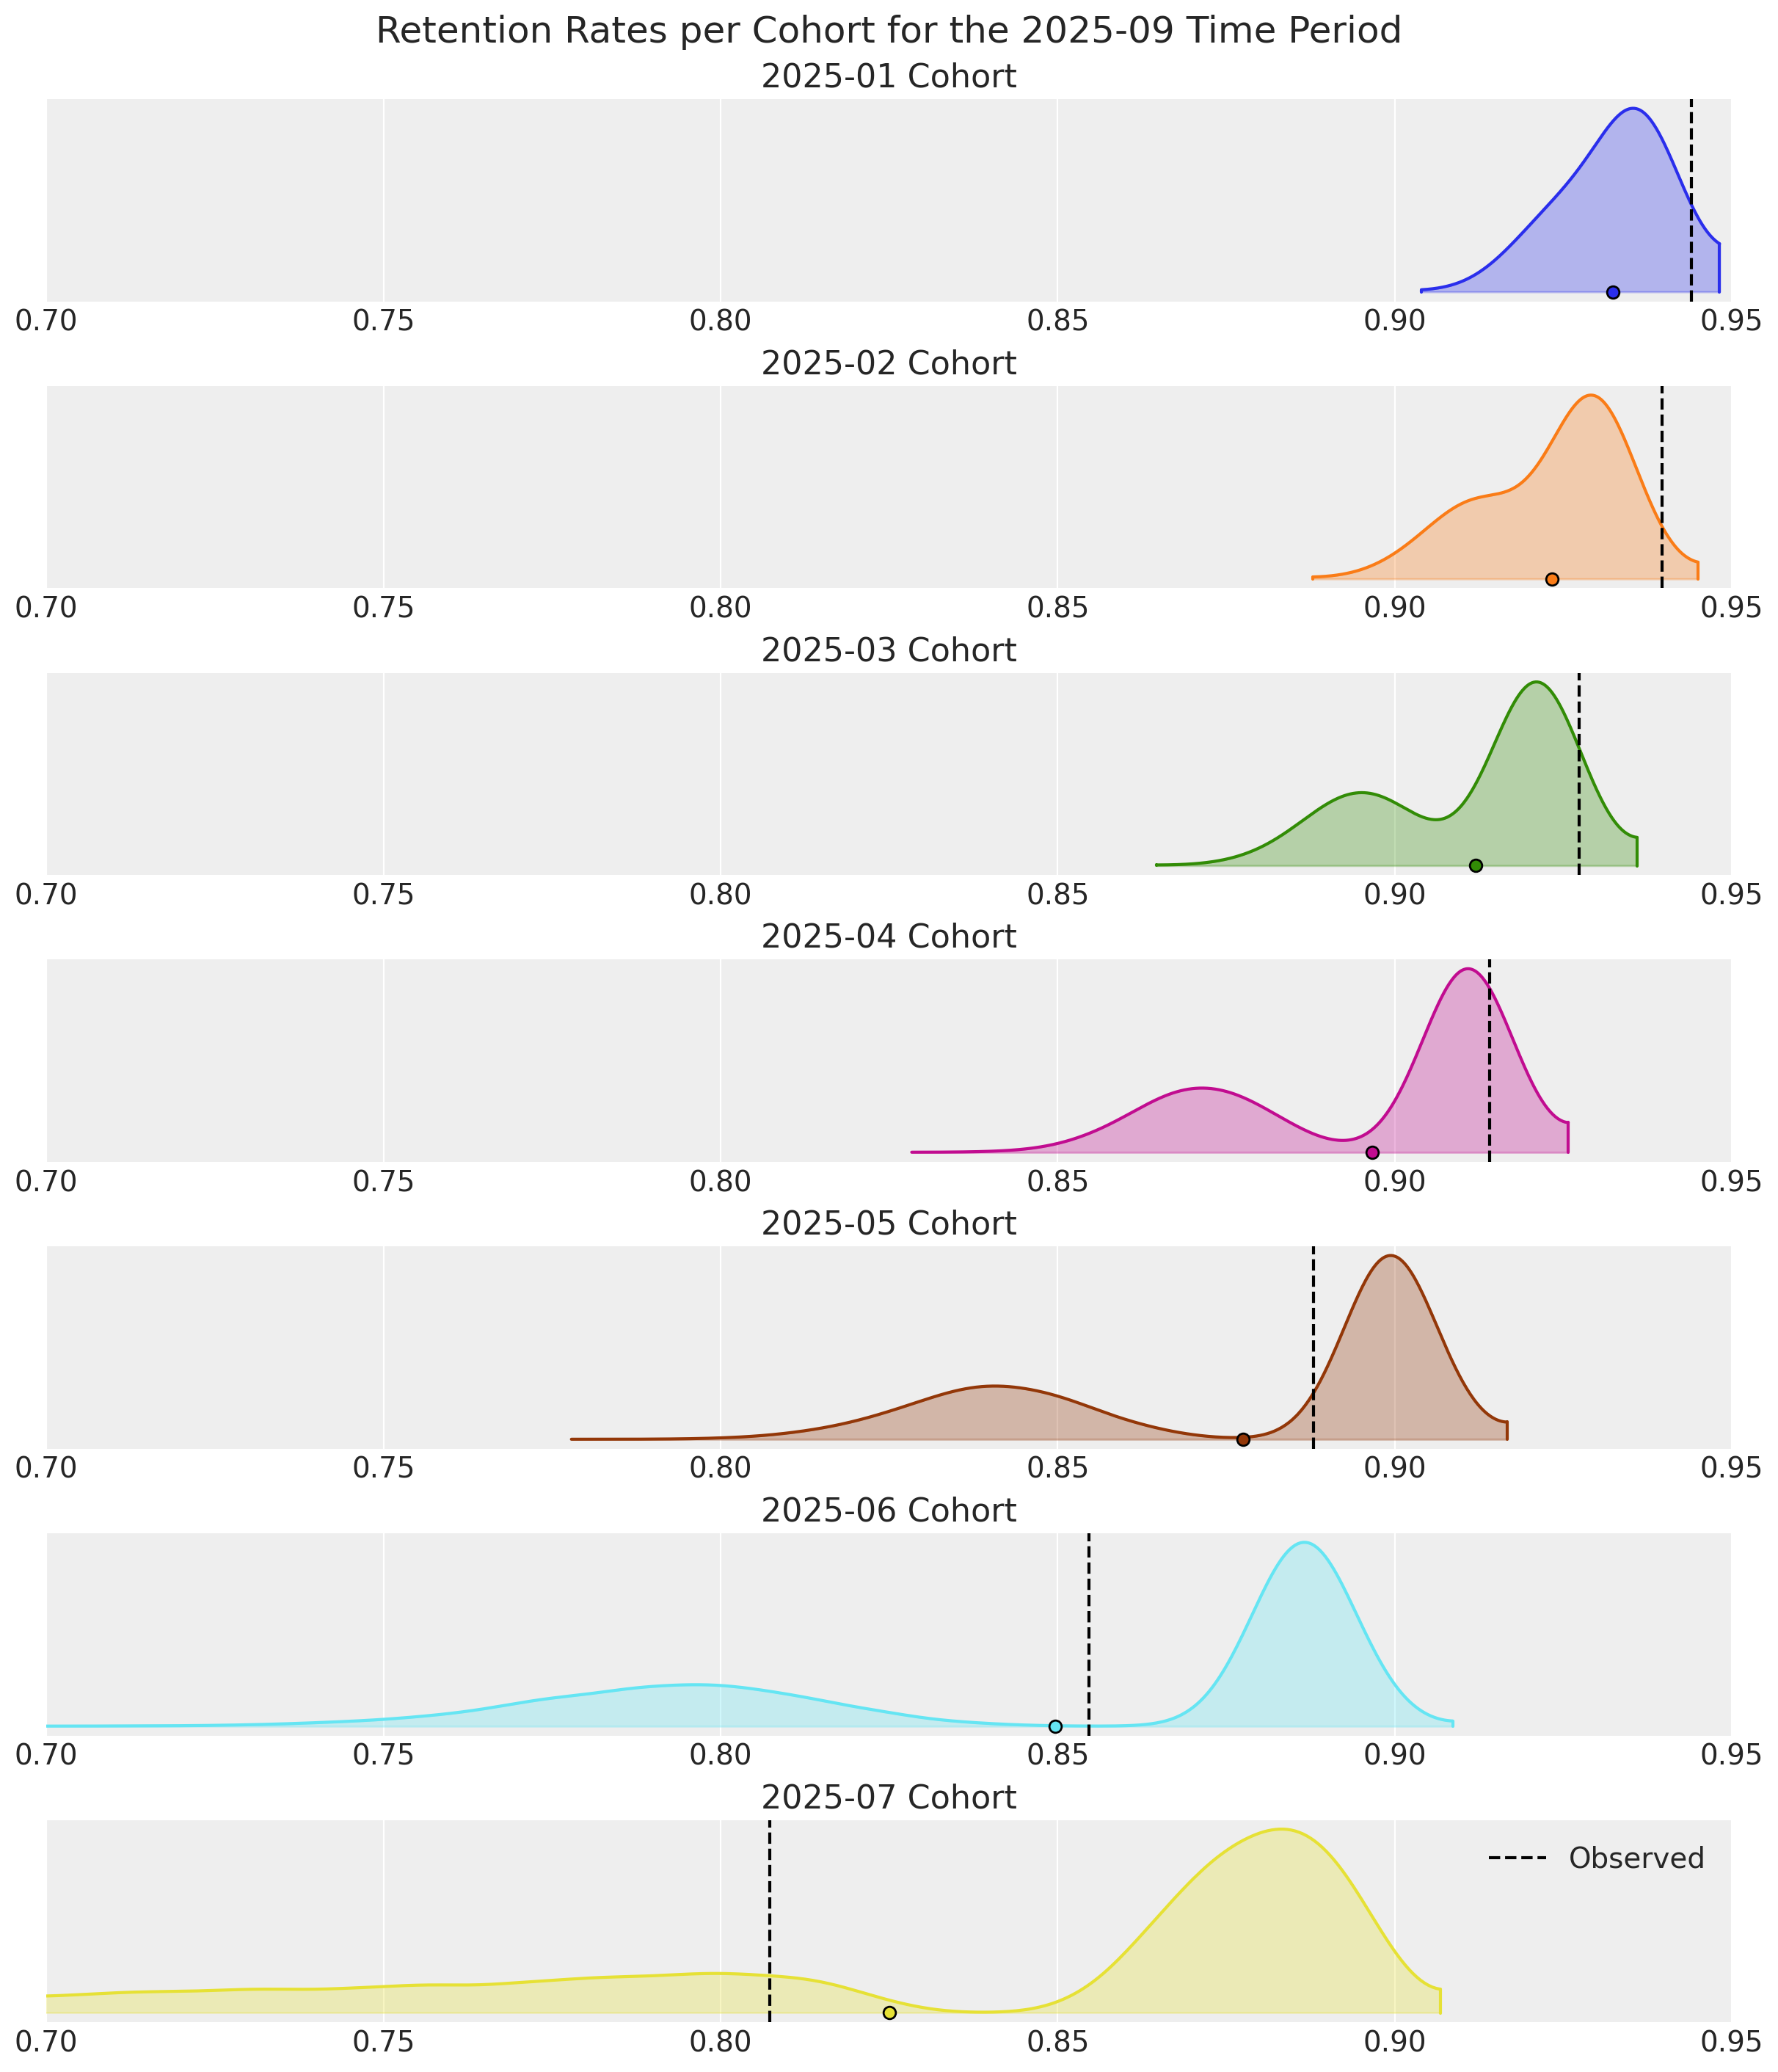

In [34]:
active_customers = monthly_cohort_dataset.query("recency==T").copy()
retention_rate_agg = base_survival[1:] / base_survival[:-1]

_, axes = plt.subplots(
    nrows=7,
    ncols=1,
    figsize=(12, 14),
    layout="constrained",
)

axes = axes.flatten()

for i, month in enumerate(cohort_start_dates):
    active_customers = monthly_cohort_dataset.query("recency==T").copy()
    active_monthly = active_customers[active_customers["cohort"] == month].copy()

    ax = axes[i]
    active_monthly = active_customers[active_customers["cohort"] == month].copy()
    cohort_retention = sbg_cohort.expected_retention_rate(
        data=active_monthly,
        future_t=0,
    ).sel(cohort=month)

    az.plot_density(
        cohort_retention, hdi_prob=1, colors=f"C{i}", shade=0.3, bw=0.005, ax=ax
    )
    ax.axvline(x=retention_rate_agg[7 - i], color="k", linestyle="--", label="Observed")
    ax.set(
        title=f"{month} Cohort",
        xlim=[0.70, 0.95],
    )
plt.legend()
plt.gcf().suptitle(
    "Retention Rates per Cohort for the 2025-09 Time Period", fontsize=18
);

Survival rates are good snapshots of model performance, but retention rates for the current time period are more useful in practice because they give an indication of which customers to prioritize now for marketing efforts.

For the record, the survival curves are spot-on when the model is fit to the same dataset sans covariates. However, retention estimates would be unimodal, providing no insight for why observed rates drift further into the tail regions. This highlights the importance of customer heterogeneity as a modeling consideration, the advantages of doing so with covariates, and why both survival *and* retention rates should be inspected after fitting.

## Discounted Residual Lifetime and Retention Elasticity
These additional predictive methods were introduced in the follow-up research paper ["Customer Base Valuation in a Contractual Setting: The Perils of Ignoring Heterogeneity"](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf) by Hardie & Fader in 2010.

### Discounted Expected Residual Lifetime

With [`ShiftedBetaGeoModel.expected_residual_lifetime()`](https://www.pymc-marketing.io/en/stable/api/generated/classmethods/pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_residual_lifetime.html#pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_residual_lifetime), we can estimate the average remaining number of time periods a cohort of customers will be active. A discount rate parameter is provided to calculate Net Present Value (NPV). It is always recommended to use a discount rate as an industry best practice.

Given how well the segment covariates explain the heterogeneity uncovered earlier, we will calculate DERL between segments separately with a 10% discount rate. Note this is very high discount rate - it is equivalent to saying purchases made $9$ time periods from now have zero value!

In [35]:
discount_rate = 0.10

# filter pred data by covariate value
active_reg = active_customers.query("highend_customer==0").copy()
active_hi = active_customers.query("highend_customer==1").copy()

# run DERL predictions on both segments, and rename for plotting
derl_reg = sbg_cohort.expected_residual_lifetime(
    data=active_reg,
    discount_rate=discount_rate,
).rename("DERL")

derl_hi = sbg_cohort.expected_residual_lifetime(
    data=active_hi,
    discount_rate=discount_rate,
).rename("DERL")

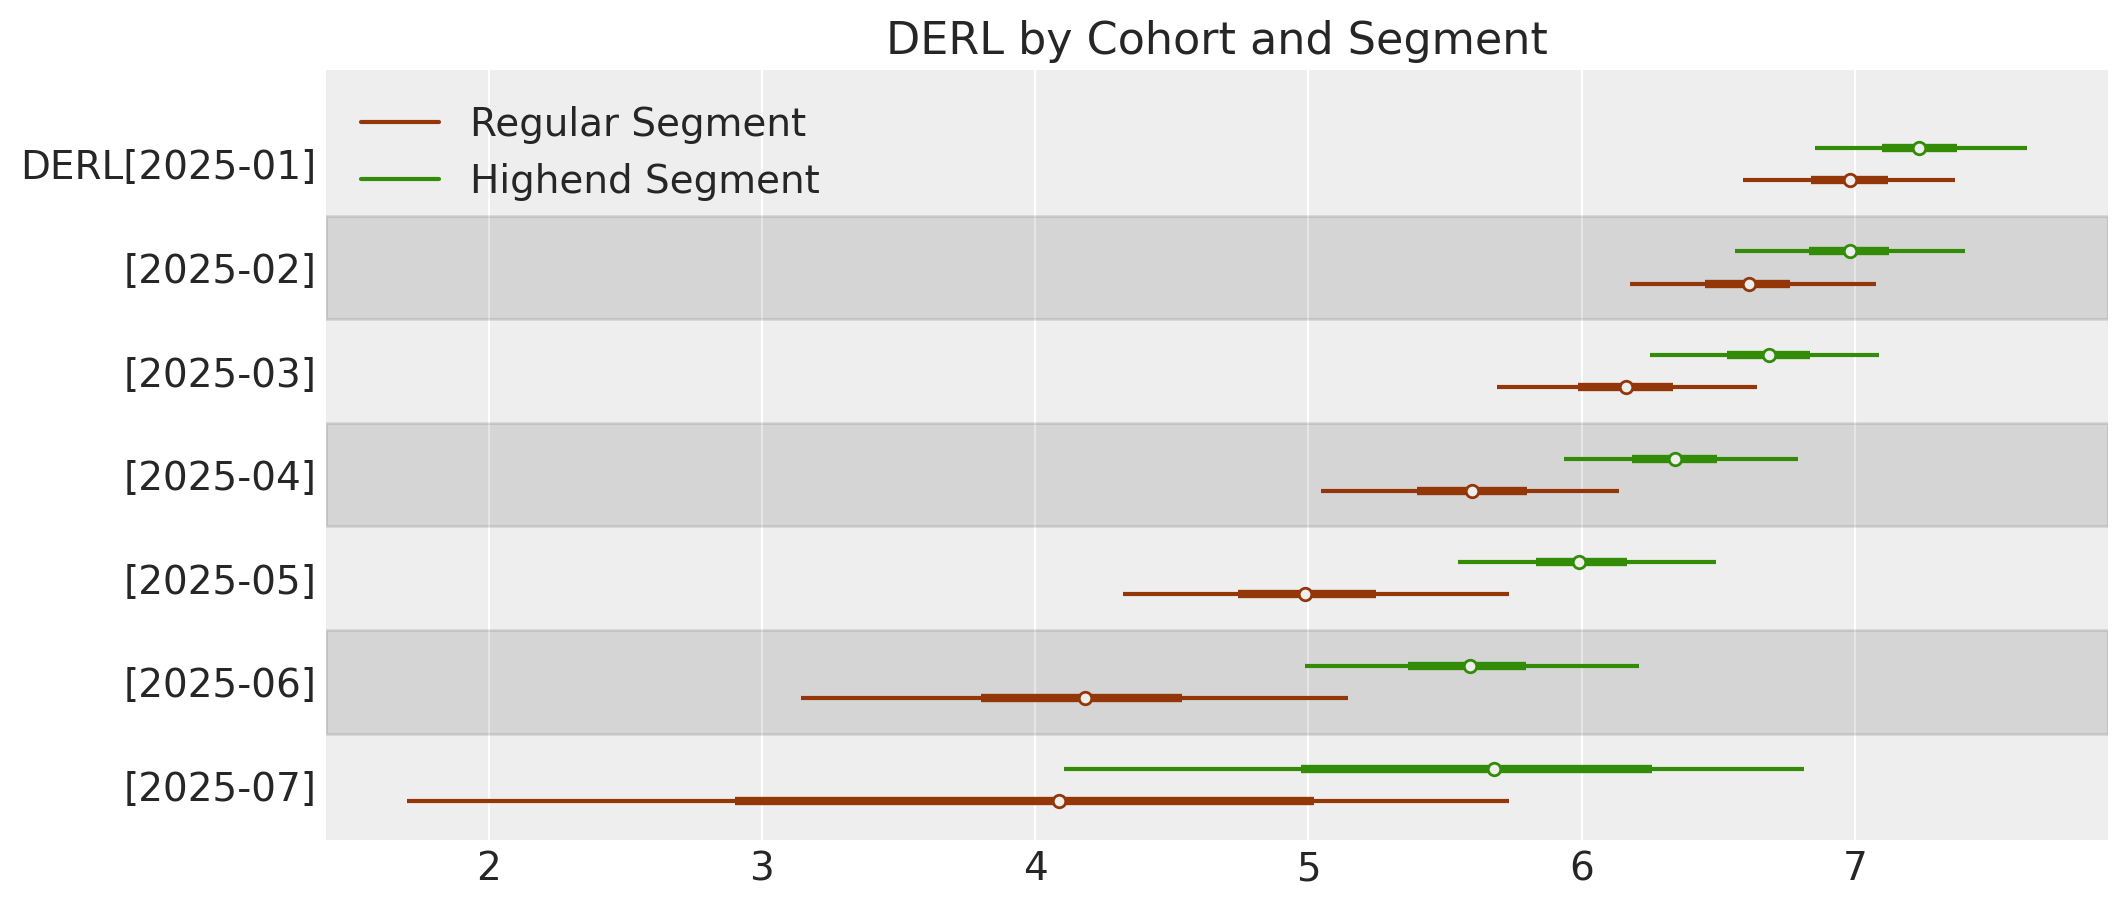

In [36]:
ax = az.plot_forest(
    [derl_hi, derl_reg],
    model_names=["Highend Segment", "Regular Segment"],
    combined=True,
    figsize=(11.5, 5),
    colors=["C2", "C4"],
    ridgeplot_quantiles=[0.5],
)
ax[0].set_title("DERL by Cohort and Segment");

We can see the segment DERL estimates in the later cohorts are quite different and broadly distributed, but over time variance decreases and segments become more similar.

### Discounted Expected Retention Elasticity

With [`ShiftedBetaGeoModel.expected_retention_elasticity()`](https://www.pymc-marketing.io/en/stable/api/generated/classmethods/pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_retention_elasticity.html#pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_retention_elasticity), we can estimate the % increase in residual lifetime given a 1% increase in the retention rate. This is very useful for causal studies on customer lifetime durations. It is recommended to apply a discount rate for elasticity as well.

In [37]:
# run DERL predictions on both segments
elastic_reg = sbg_cohort.expected_retention_elasticity(
    data=active_reg,
    discount_rate=discount_rate,
)  # )

elastic_hi = sbg_cohort.expected_retention_elasticity(
    data=active_hi,
    discount_rate=discount_rate,
)

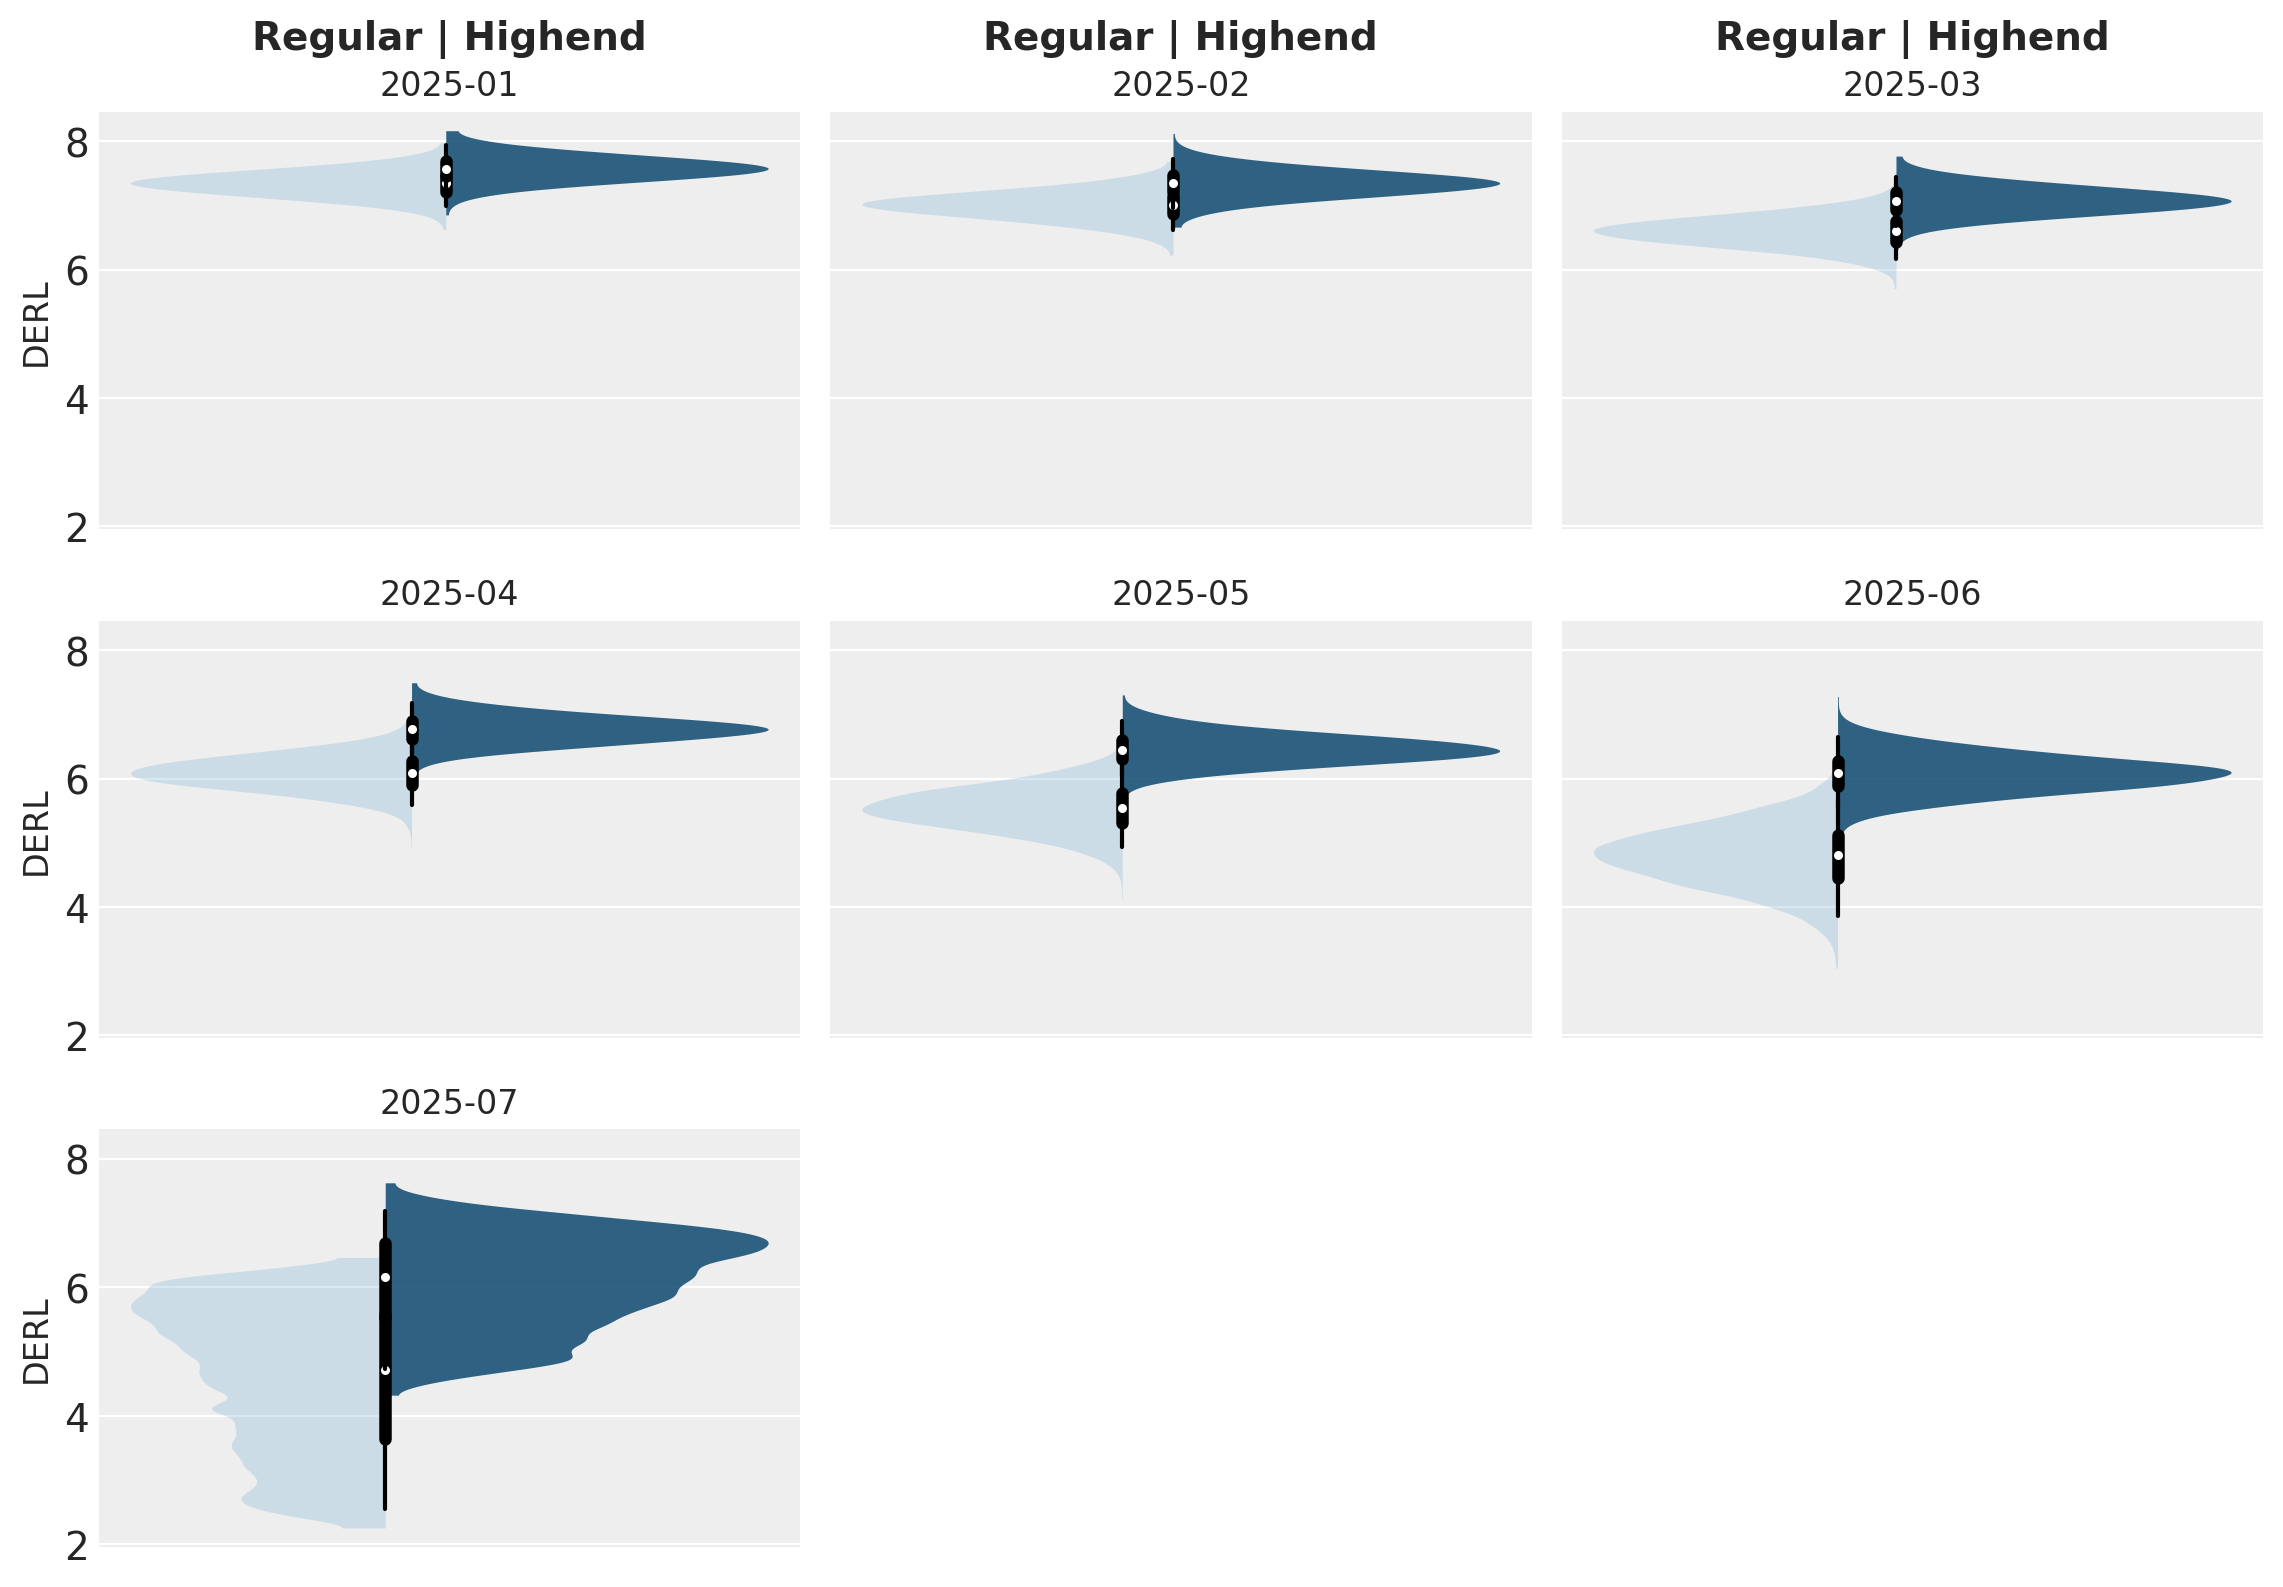

In [38]:
# Create figure
fig, axes = plt.subplots(3, 3, figsize=(11.5, 8), sharey=True)
axes = axes.flatten()

cohorts = sbg_cohort.cohorts

# Plot each cohort
for i, cohort in enumerate(cohorts):
    if i >= len(axes):
        break
    ax = axes[i]

    # Plot regular (left side) - lighter color
    az.plot_violin(
        elastic_reg.sel(cohort=cohort),
        side="left",
        ax=ax,
        shade=0.3,
        bw=0.1,
        shade_kwargs={"color": "#7FB3D5"},  # Light blue
        show=False,
    )

    # Plot highend (right side) - darker color
    az.plot_violin(
        elastic_hi.sel(cohort=cohort),
        side="right",
        ax=ax,
        shade=0.9,
        bw=0.1,
        shade_kwargs={"color": "#1A5276"},  # Dark blue
        show=False,
    )

    ax.set_title(cohort, fontweight="normal", fontsize=12)

    # Add y-label only to leftmost plots
    if i % 3 == 0:
        ax.set_ylabel("DERL", fontsize=12)
    else:
        ax.set_ylabel("")

# Add "Regular | Highend" suptitle only to top row
for i in range(min(3, len(cohorts))):
    axes[i].annotate(
        "Regular | Highend",
        xy=(0.5, 1.15),
        xycoords="axes fraction",
        ha="center",
        fontsize=14,
        fontweight="bold",
    )

# Hide unused subplots
for i in range(len(cohorts), len(axes)):
    axes[i].set_visible(False)

fig.tight_layout()
plt.show();

Retention elasticity is higher for earlier, long-running cohorts, but these retention rates also approach 95%. If retention were to be increased by just 5% for Regular customers in the 2025-07 cohort, their respective remaining lifetimes could be 25% longer!

The [`xarray`](https://docs.xarray.dev/en/stable/) outputs we've been working with for the sBG predictive methods can also be converted to dataframes for downstream handling:

In [39]:
# filter dataset to only active customers
pred_data = monthly_cohort_dataset.query("recency==T")

# predict retention rate and convert to dataframe
pred_cohort_retention = sbg_cohort.expected_retention_rate(pred_data, future_t=0).mean(
    ("chain", "draw")
)
pred_cohort_retention.to_dataframe(name="retention").reset_index()

cohort  customer_id  retention
0     2025-01          510   0.936442
1     2025-01          511   0.936442
2     2025-01          512   0.936442
3     2025-01          513   0.936442
4     2025-01          514   0.936442
...       ...          ...        ...
7011  2025-07        13996   0.749574
7012  2025-07        13997   0.749574
7013  2025-07        13998   0.749574
7014  2025-07        13999   0.749574
7015  2025-07        14000   0.749574

[7016 rows x 3 columns]

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Tue Dec 16 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pymc    : 5.25.1
pytensor: 2.31.7

pymc          : 5.25.1
pytensor      : 2.31.7
pandas        : 2.3.1
xarray        : 2025.7.1
pymc_extras   : 0.4.0
matplotlib    : 3.10.3
dateutil      : 2.9.0.post0
numpy         : 2.2.6
arviz         : 0.22.0
pymc_marketing: 0.17.0
seaborn       : 0.13.2

Watermark: 2.5.0

